In [1]:
import os, sys
sys.path.append('/Users/scheng/Documents/GitHub')

import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, vstack, hstack
from astropy.io import fits
from astropy.coordinates import SkyCoord  # High-level coordinates
from astropy.coordinates import ICRS, Galactic # Low-level frames
import astropy.units as u
from scipy.interpolate import interp2d, interp1d

import importlib
import WD_HR
import WD_models as WD_models
import WD_MCMC_func

In [2]:
def number_of_branch(WD,distance2=200,v_lim=60):
    mass_min    = 1.08#1.10
    mass_max    = 1.23#1.28
    distance1   = 0
    atm_type    = 'H'
    model       = 'o'
    age_lim     = 3.5
    
    WD = WD.copy()
    WD['mass']  = WD['mass_' + atm_type + '_' + model]
    WD['age']   = WD['age_' + atm_type + '_' + model]
    Q_branch    = np.array((WD['mass'] > mass_min) *
                           (WD['mass'] < mass_max) *
                           (1/WD['parallax']*1000 > distance1) *
                           (1/WD['parallax']*1000 < distance2) *
                           WD_HR.func_select(WD['bp_rp'],
                                             WD['G'],
                                             13.20, 1.2, 0.20, -0.40, 0.10)
                          )
    WD_Q    = WD[Q_branch]
    WD      = WD[np.array((WD['mass'] > mass_min) *
                          (WD['mass'] < mass_max) *
                          (1/WD['parallax']*1000 > distance1) *
                          (1/WD['parallax']*1000 < distance2) *
                          ~Q_branch )]
    
    print('length of WD: ',len(WD), 'length of WD_Q: ',len(WD_Q))
    
    stromberg_k = 80
    pml, pmb, factor        = WD_MCMC_func.prep_get_v(WD)
    pml_Q, pmb_Q, factor_Q  = WD_MCMC_func.prep_get_v(WD_Q)
    v_drift                 =   (((WD['age'] + 0.1) / 10.1)**0.2 * 40)**2 / stromberg_k
    v_drift_Q               = (((WD_Q['age'] + 0.1) / 10.1)**0.2 * 40)**2 / stromberg_k
    vL, vB                  = np.array(WD_MCMC_func.get_v_delayed_3D(WD['age'], WD['l'], WD['b'],
                                                                     pml, pmb, factor, v_drift,
                                                                     10.5, 7.5, 6.5))
    vL_Q, vB_Q              = np.array(WD_MCMC_func.get_v_delayed_3D(WD_Q['age'], WD_Q['l'], WD_Q['b'],
                                                                     pml_Q, pmb_Q, factor_Q, v_drift_Q,
                                                                     10.5, 7.5, 6.5))
    
    selection   = np.array((WD['age'] < age_lim) * (WD['age'] > 0.1) * 
                       ((vL**2 + vB**2)**0.5 < 250)) #(np.abs(vL<200))*(np.abs(vB<200))
    mass        = np.array(WD['mass'][selection])
    age         = np.array(WD['age'][selection])
    l           = np.array(WD['l'][selection])
    b           = np.array(WD['b'][selection])
    vL          = vL[selection]
    vB          = vB[selection]
    pml         = pml[selection]
    pmb         = pmb[selection]
    factor      = factor[selection]
 
    selection_Q = np.array((WD_Q['age'] < age_lim) * (WD_Q['age'] > 0.1) * 
                           ((vL_Q**2 + vB_Q**2)**0.5 < 250))
    mass_Q      = np.array(WD_Q['mass'][selection_Q])
    age_Q       = np.array(WD_Q['age'][selection_Q])
    l_Q         = np.array(WD_Q['l'][selection_Q])
    b_Q         = np.array(WD_Q['b'][selection_Q])
    vL_Q        = vL_Q[selection_Q]
    vB_Q        = vB_Q[selection_Q]
    pml_Q       = pml_Q[selection_Q]
    pmb_Q       = pmb_Q[selection_Q]
    factor_Q    = factor_Q[selection_Q]
    
    WD_Q        = WD_Q[selection_Q]
    WD          = WD[selection]
    WD_Q['pml'] = pml_Q
    WD_Q['pmb'] = pmb_Q
    WD_Q['factor'] = factor_Q
    WD['pml']   = pml
    WD['pmb'] = pmb
    WD['factor'] = factor
    
    early       = np.array(1.22 - (age - 0.6) * 0.2 > mass) #for ONe: 1.22; CO: 1.25
    late        = np.array(1.22 - (age - 0.6) * 0.2 < mass) 

    print('after selection:\nlength of WD+WD_Q: ', selection.sum() + selection_Q.sum())
    print('length of early: ',early.sum(), 'length of WD_Q: ',len(WD_Q), 'length of late: ',late.sum())
    print('fast: early:', (WD[early]['v']>v_lim).sum(), 
          'Q: ', (WD_Q['v']>v_lim).sum(),
          'late: ',(WD[late]['v']>v_lim).sum())
    return WD, WD_Q, (selection.sum() + selection_Q.sum(), early.sum(), len(WD_Q), late.sum(),
           (WD[early]['v']>v_lim).sum(), (WD_Q['v']>v_lim).sum(), (WD[late]['v']>v_lim).sum()),\
            early, late, vL, vL_Q, vB, vB_Q


c80 = np.array([[1.535344,15.55093],
[1.373237,15.35719],
[1.099449,14.9134],
[0.9608346,14.78926],
[0.8040217,14.63826],
[0.5154436,14.18007],
[0.2752975,13.733],
[0.085686848,13.37667],
[-0.1101898,13.16182],
[-0.3026432,13.15815]])

c20 = np.array([[1.337226,15.04411],
[1.138313,14.78903],
[0.9187554,14.4683],
[0.6075018,13.94357],
[0.352008,13.45582],
[0.1696938,13.07261],
[-0.01402621,12.72583],
[-0.1516954,12.64695],
[-0.2914764,12.58182],
[-0.475993,12.36557]])

def plot_analytical(factor=3, atm_type='H', color='C0', lw=3):
    mass = np.arange(0.6, 1.29, 0.01)
    logm = np.log10(mass)
    model = WD_models.load_model('','f','f',atm_type)
    logm_logt_to_logL = WD_models.interp_xy_z_func(x=np.log10(model['mass_array']),
                                                   y=model['logteff'],
                                                   z=(4.75-model['Mbol'])/2.5,
                                                   interp_type='linear',
                                                   )
    logm_logt_to_color = WD_models.interp_xy_z_func(x=np.log10(model['mass_array']),
                                                    y=model['logteff'],
                                                    z=model['color'],
                                                    interp_type='linear',
                                                    )
    logm_logt_to_Mag = WD_models.interp_xy_z_func(x=np.log10(model['mass_array']),
                                                  y=model['logteff'],
                                                  z=model['Mag'],
                                                  interp_type='linear',
                                                  )
    const = -3.26 + np.log10(factor) + 0 - np.log10(1.22) + np.log10(0.014/0.02)\
            + ((logm_logt_to_logL(np.log10(1.06), 4) - 4*4 + np.log10(5777)*4) / 2)*1.89\
            - np.log10(1.06)*2.25 - (4.5)*0.54 
    #       L_Ne + D/Ds*[M/H] + Lsurf/L_Ne - C/CO + Z0014/Z002
    #       + R
    #       - M - Teff
    logr = (logm_logt_to_logL(logm, 4) - 4*4 + np.log10(5777)*4) / 2
    logt = (logm*2.25 - logr*3.89 + np.log10(5777)*4 + const)/3.46
    select = 10**logt > 5500
    plt.plot(logm_logt_to_color(logm[select], logt[select]),
             logm_logt_to_Mag(logm[select], logt[select]),
             color=color, lw=lw)
    
    const = -3.26 + np.log10(factor) + 0.087 - np.log10(1.22) + np.log10(0.014/0.02)\
            + ((logm_logt_to_logL(np.log10(1.06), 4) - 4*4 + np.log10(5777)*4) / 2)*1.89\
            - np.log10(1.06)*2.25 - (4.5)*0.54 
    logr = (logm_logt_to_logL(logm, 4) - 4*4 + np.log10(5777)*4) / 2
    logt = (logm*2.25 - logr*3.89 + np.log10(5777)*4 + const)/3.46
    select = 10**logt > 5500
    plt.plot(logm_logt_to_color(logm[select], logt[select]),
             logm_logt_to_Mag(logm[select], logt[select]),ls='dashed',
             color=color, lw=lw)

#     const = -3.26 + np.log10(factor)+0.15 - np.log(1.27) + ((logm_logt_to_logL(np.log10(1.06), 4) - 4*4 + np.log10(5777)*4) / 2)*1.89\
#             - np.log10(1.06)*2.25 - (4.5)*0.54 
#     logr = (logm_logt_to_logL(logm, 4) - 4*4 + np.log10(5777)*4) / 2
#     logt = (logm*2.31 - logr*3.84 + np.log10(5777)*4 + const)/3.46
#     select = 10**logt > 5500
#     plt.plot(logm_logt_to_color(logm[select], logt[select]),
#              logm_logt_to_Mag(logm[select], logt[select]),
#              color=color, lw=lw)
#     logt = (logm*0.59 - logr*1.18 + np.log10(5777)*4 -9 - 4.56)
#     plt.plot(logm_logt_to_color(logm, logt),
#              logm_logt_to_Mag(logm, logt),
#              )

def plot_HR(WD, x,y,xerr,yerr,distance1=0,distance2=200,alpha=1,color='gray',plot=True, box=False, grid=False,
            if_select=True, legend_on=True, plot_arrow=True, gif_legend=None, zorder=1, age=None, 
            age_colorbar_param=None, one_grid=False, highmass=None):
    if if_select==True:
        distance_select = ((1/WD['parallax']*1000>distance1)*(1/WD['parallax']*1000<distance2)*(WD['bp_rp']<0.35)+\
                       (1/WD['parallax']*1000>distance1)*(1/WD['parallax']*1000<distance2)*(WD['bp_rp']>0.35))\
            * (WD['G']<15) * (xerr<1.0) * (WD['b']>-100) * (WD['l']<1180) \
            * ~((((WD['pmra'])**2+WD['pmdec']**2)**0.5*WD['parallax']<10*10) * (WD['astrometric_excess_noise']>1)\
            * ((WD['mass_H_o']<0.55)+np.isnan(WD['mass_H_o'])) )
        fast = WD['v']>70
        massive = WD['mass_H_o']>1.075
        selected_Q_branch = WD_HR.func_select(WD['bp_rp'],WD['G'],13.20,1.2,0.20,-0.40,0.10)
    else:
        distance_select = x<10e30
        selected_Q_branch = WD_HR.func_select(x,y,13.20,1.2,0.20,-0.40,0.10)
    
    print(distance_select.sum())
    print((selected_Q_branch*distance_select).sum())

    if plot == True:
        #plot gray
        if age is None:
            if gif_legend is not None:
                ax = plt.plot(x[distance_select],y[distance_select],\
                        ls='none',ms=1,marker='o',color=color,alpha=alpha,zorder=zorder)
                plt.plot([-100],[-100],\
                    ls='none',ms=10,marker='o',color=color,alpha=alpha,
                   label=gif_legend)
                plt.legend(fontsize=17,loc=1)
            else:
                if highmass is not None:
                    highmass = (WD['mass_'+atm_type+'_'+model]>highmass)+(WD['G']-14>WD['bp_rp']*3/0.6)
                    plt.plot(x[distance_select*highmass],y[distance_select*highmass],\
                        ls='none',ms=1,marker='o',color=color,alpha=alpha,
                       label='WDs within '+str(distance2)+' pc')
                    ax = plt.plot(x[distance_select],y[distance_select],\
                        ls='none',ms=1,marker='o',color=color,alpha=0.1,zorder=zorder)
                else:
                    ax = plt.plot(x[distance_select],y[distance_select],\
                        ls='none',ms=1,marker='o',color=color,alpha=alpha,
                       label='WDs within '+str(distance2)+' pc')
                if legend_on == True:
                    plt.legend(fontsize=15,loc=3)
        # plot age
        else:
            ax = plt.subplot(1,1,1)
            plt.axes()
            plt.scatter(x, y, c=age, vmin=0,vmax=7,cmap='cool', marker='o', s=1, alpha=alpha,)
            plt.colorbar(orientation='horizontal',**age_colorbar_param)
            plt.sca(ax)
            
        if plot_arrow == True:
            plt.arrow(-0.35,13.9,0.15,-0.75,length_includes_head=True,
              head_length=0.1,head_width=0.05,shape='full',overhang=0.1,width=0.01,
             fc='r', ec='r',zorder=4)
            plt.text(-0.5,14.1,'Q branch',color='r',fontsize=17)
    if box == True:
            #plot box
        WD_HR.plot_func_select_box(13.20,1.2,0.20,-0.40,0.10,color='r',lw=2,ls='solid')
        plt.arrow(-0.35,13.9,0.15,-0.75,length_includes_head=True,
              head_length=0.1,head_width=0.05,shape='full',overhang=0.1,width=0.01,
             fc='r', ec='r',zorder=4)
        plt.text(-0.5,14.1,'Q branch',color='r',fontsize=17)
    
    #grid
    if grid == True:
        ax = plt.contour(WD_model['grid_HR_to_mass'].T,levels=[0.5,0.7,0.9,1.1,1.2883],
                         linestyles='solid',cmap='jet',
                         extent=(HR_grid[0],HR_grid[1],HR_grid[3],HR_grid[4]),
                         alpha=alpha, vmax=1000, zorder=3)

        CS = plt.contour(WD_model['grid_HR_to_age_cool'].T + 
                         WD_models.MS_age(WD_model['grid_HR_to_mass'].T)*1e-9,
                         levels=[1,2,3,4,5,6,7,8,9,10,11,12,13],
                         linestyles='solid', cmap='jet',
                         extent=(HR_grid[0],HR_grid[1],HR_grid[3],HR_grid[4]),
                         alpha=alpha,vmin=-1000,zorder=3)
        
        if legend_on==True:
            l1, = plt.plot([0,1],[0,1],ls='solid',color=(0.0, 0.0, 0.5, 1.0),alpha=alpha,zorder=4,
                 label="WD mass: $m_{\\rm{WD}}$")
            l2, = plt.plot([0,1],[0,1],ls='solid',color=(0.5, 0.0, 0.0, 1.0),alpha=alpha,zorder=4,
                 label="WD age: $t_{\\rm{cooling}}+t_{\\rm{MS}}$")
            plt.legend()
        # label of mass contour
        plt.text(-0.39,10.1,'$0.5\\rm{M_\odot}$',rotation=-60,fontsize=15,color=(0,0,0.5,1.0),alpha=alpha)
        plt.text(-0.46,10.3,'$0.7\\rm{M_\odot}$',rotation=-60,fontsize=15,color=(0,0,0.5,1.0),alpha=alpha)
        plt.text(-0.51,10.5,'$0.9\\rm{M_\odot}$',rotation=-65,fontsize=15,color=(0,0,0.5,1.0),alpha=alpha)
        plt.text(-0.57,10.7,'$1.1\\rm{M_\odot}$',rotation=-70,fontsize=15,color=(0,0,0.5,1.0),alpha=alpha)
        plt.text(-0.56,12,'$1.29\\rm{M_\odot}$',rotation=-70,fontsize=15,color=(0,0,0.5,1.0),alpha=alpha)
        # label of age contour
        plt.text(-0.32+0.05,13.25,'$1\\rm{Gyr}$',rotation=70,fontsize=15,color=(0.5,0,0.0,1.0),alpha=alpha)
        plt.text(-0.045+0.05,13.9,'$2\\rm{Gyr}$',rotation=80,fontsize=15,color=(0.5,0,0.0,1.0),alpha=alpha)
        plt.text(0.21+0.05,14.8,'$3\\rm{Gyr}$',rotation=90,fontsize=15,color=(0.5,0,0.0,1.0),alpha=alpha)
        plt.text(0.42+0.05,14.7,'$4\\rm{Gyr}$',rotation=115,fontsize=15,color=(0.5,0,0.0,1.0),alpha=alpha)
        plt.text(0.58+0.05,14.7,'$5\\rm{Gyr}$',rotation=60,fontsize=15,color=(0.5,0,0.0,1.0),alpha=alpha)
        plt.text(0.77+0.05,14.83,'$6\\rm{Gyr}$',rotation=40,fontsize=15,color=(0.5,0,0.0,1.0),alpha=alpha)
    if one_grid == True:
        ax = plt.contour(WD_model['grid_HR_to_mass'].T,levels=[1.1],
                         linestyles='solid',cmap='jet',
                         extent=(HR_grid[0],HR_grid[1],HR_grid[3],HR_grid[4]),
                         alpha=alpha,vmax=1000,zorder=3)
#         plt.text(-0.51-0.05,10.5,'$1.0\\rm{M_\odot}$',rotation=-65,fontsize=15,color=(0,0,0.5,1.0),alpha=alpha)
        plt.text(-0.51-0.06,10.6,'$1.1\\rm{M_\odot}$',rotation=-70,fontsize=15,color=(0,0,0.5,1.0),alpha=alpha)
    return ax

def plot_HR_poster(WD, x,y,xerr,yerr,distance1=0,distance2=200,alpha=1,color='gray', box=False,
            if_select=True, legend_on=True, plot_arrow=True,zorder=1,
            age_colorbar_param=None, alpha_lowmass=0.1,alpha_highmass=0.5,alpha_highfast=1,
             alpha_grid=0.5, order_grid=-1, colorbar_on=True, vel_colorbar_param=None,
                  one_grid=False):
    if if_select==True:
        distance_select = ((1/WD['parallax']*1000>distance1)*(1/WD['parallax']*1000<distance2)*(WD['bp_rp']<0.35)+\
                       (1/WD['parallax']*1000>distance1)*(1/WD['parallax']*1000<distance2)*(WD['bp_rp']>0.35))\
            * (WD['G']<15) * (xerr<1.0) * (WD['b']>-100) * (WD['l']<1180) \
            * ~((((WD['pmra'])**2+WD['pmdec']**2)**0.5*WD['parallax']<10*10) * (WD['astrometric_excess_noise']>1)\
            * ((WD['mass_H_o']<0.55)+np.isnan(WD['mass_H_o'])) )
        fast = WD['v']>v_max
        massive = (WD['mass_H_o']>mass_min)+(WD['G']-14>WD['bp_rp']*3/0.6)
        selected_Q_branch = WD_HR.func_select(WD['bp_rp'],WD['G'],13.20,1.2,0.20,-0.40,0.10)
    else:
        distance_select = x<10e30
        selected_Q_branch = WD_HR.func_select(x,y,13.20,1.2,0.20,-0.40,0.10)
    
    print(distance_select.sum())
    print((selected_Q_branch*distance_select).sum())
    
    #plot all, massive
    s1= plt.scatter(x[distance_select*(massive)],y[distance_select*(massive)],\
                c=WD['v'][distance_select*(massive)],vmin=0,vmax=70,cmap='cool',
                    marker='o',s=1,alpha=alpha_highmass,
               label="WDs within "+str(distance2)+" pc",zorder=5)
    
       #plot >70km/s
    s2= plt.scatter(x[distance_select*fast*massive],y[distance_select*fast*massive],\
                s=5,color=(1,0,1,1), alpha=alpha_highfast,
               label="$v_{\\rm T}>"+str(v_max)+"{\\rm \\,km\\,s^{-1}}$",zorder=0)

    if REGIONS == True:
        # early and late
        plt.plot([-0.305,0.12,-0.07,-0.42,-0.305],[13.04,13.52,12.92,12.50,13.04],ls='solid',lw=3,\
             color='r')
        plt.text(0,13,'Q branch',color='r',fontsize=text_size+size_excess)
        plt.plot([0.27,0.02,-0.29,0.12,0.37,0.39,0.38],[15,14.05,13.08,13.55,14.4,14.7,15],ls='solid',lw=3,\
             color='lightseagreen')
        plt.text(-0.3,13.9,'late',color='lightseagreen',fontsize=text_size+size_excess)
        plt.plot([-0.42,-0.55,-0.52,-0.33,-0.10,-0.42],[12.49,11.65,11.11,12.05,12.85,12.49],ls='solid',lw=3,\
             color='lightseagreen')
        plt.text(-0.3,12,'early',color='lightseagreen',fontsize=text_size+size_excess)
    
        # label of mass, age limit
        plt.text(0.33,14.6,'$3.5 \\rm{Gyr}$',rotation=95,fontsize=text_size,color=(0.5,0,0.0,1.0))
        plt.text(-0.58,11.27,'$0.1 \\rm{Gyr}$',rotation=80,fontsize=text_size,color=(0.5,0,0.0,1.0))
        
        plt.text(0.22,13.87,'$1.08\\rm{M_\odot}$',rotation=-50,fontsize=text_size,color=(0,0,0.5,1.0))
        plt.text(0.09,14.3,'$1.23\\rm{M_\odot}$',rotation=-50,fontsize=text_size,color=(0,0,0.5,1.0))
            
    if GRID == True:
        # plot mass-age grids
        xy = (-0.6, 1.5, 0.002, 10, 15, 0.01)
        CS = plt.contour(WD_model['grid_HR_to_mass'].T,levels=[0.5,0.7,0.9,1.1,1.2883],
                         linestyles='dashed',cmap='jet',
                         extent=(HR_grid[0],HR_grid[1],HR_grid[3],HR_grid[4]),
                         alpha=alpha_grid,vmax=1000,zorder=order_grid)
        #CS = plt.contour(WD_models.DA_thick_CO['grid_mass'].T,levels=[0.5,0.7,0.9,1.09,1.27],
        #             linestyles='dashed',cmap='jet',\
        #        extent=(xy[0],xy[1],xy[3],xy[4]),\
        #        origin='lower',aspect='auto',alpha=0.5,vmin=-1000,zorder=-1)
        CS = plt.contour(WD_model['grid_HR_to_age'].T,levels=[1,2,3,4,5,6,7,8,9,10,11,12,13],
                         linestyles='dashed', cmap='jet',
                         extent=(HR_grid[0],HR_grid[1],HR_grid[3],HR_grid[4]),
                         alpha=alpha_grid, vmin=-1000, zorder=order_grid) 
                     
        l1, = plt.plot([0,1],[0,1],ls='dashed',color=(0.0, 0.0, 0.5, 1.0),alpha=alpha_grid,zorder=4,
             label="WD mass: $m_{\\rm{WD}}$")
        l2, = plt.plot([0,1],[0,1],ls='dashed',color=(0.5, 0.0, 0.0, 1.0),alpha=alpha_grid,zorder=4,
             label="WD age: $t_{\\rm{cooling}}+t_{\\rm{MS}}$")
        # label of mass contour
        plt.text(-0.39,10.1,'$0.5\\rm{M_\odot}$',rotation=-60,fontsize=text_size,color=(0,0,0.5,1.0),alpha=alpha_grid)
        plt.text(-0.46,10.3,'$0.7\\rm{M_\odot}$',rotation=-60,fontsize=text_size,color=(0,0,0.5,1.0),alpha=alpha_grid)
        plt.text(-0.51,10.5,'$0.9\\rm{M_\odot}$',rotation=-65,fontsize=text_size,color=(0,0,0.5,1.0),alpha=alpha_grid)
        plt.text(-0.57,10.7,'$1.1\\rm{M_\odot}$',rotation=-70,fontsize=text_size,color=(0,0,0.5,1.0),alpha=alpha_grid)
        plt.text(-0.56,12,'$1.29\\rm{M_\odot}$',rotation=-70,fontsize=text_size,color=(0,0,0.5,1.0),alpha=alpha_grid)
        # label of age contour
        offset = -0.05
        plt.text(-0.32+offset,13.25,'$1\\rm{Gyr}$',rotation=70,fontsize=text_size,color=(0.5,0,0.0,1.0),alpha=alpha_grid)
        plt.text(-0.045+offset,13.9,'$2\\rm{Gyr}$',rotation=80,fontsize=text_size,color=(0.5,0,0.0,1.0),alpha=alpha_grid)
        plt.text(0.21+offset,14.8,'$3\\rm{Gyr}$',rotation=90,fontsize=text_size,color=(0.5,0,0.0,1.0),alpha=alpha_grid)
        plt.text(0.42+offset,14.7,'$4\\rm{Gyr}$',rotation=115,fontsize=text_size,color=(0.5,0,0.0,1.0),alpha=alpha_grid)
        plt.text(0.58+offset,14.7,'$5\\rm{Gyr}$',rotation=60,fontsize=text_size,color=(0.5,0,0.0,1.0),alpha=alpha_grid)
        plt.text(0.77+offset,14.83,'$6\\rm{Gyr}$',rotation=40,fontsize=text_size,color=(0.5,0,0.0,1.0),alpha=alpha_grid)
        
        label_age = "WD age: $\\tau_{\\rm phot}$"
        if legend_on == True:
            plt.legend(handles=[s1, s2, l1, l2], 
                       labels=["WDs within "+str(distance2)+" pc", 
                       "$v_{\\rm T}>"+str(v_max)+"{\\rm \\,km\\,s^{-1}}$",
                       "WD mass: $m_{\\rm{WD}}$",
                       label_age,],
                       loc=3,fontsize=text_size+size_excess)
    else:
        if legend_on == True:
            plt.legend(handles=[s1, s2], 
                       labels=["WDs within "+str(distance2)+" pc", 
                               "$v_{\\rm T}>"+str(v_max)+"{\\rm \\,km\\,s^{-1}}$"],
                       loc=3,fontsize=text_size+size_excess)
    # manual legend
    plt.legend(handles=[s2],labels=["$v_{\\rm T}>"+str(v_max)+"{\\rm \\,km\\,s^{-1}}$"],loc=(0.5,0.7),fontsize=17)
        #plot all
    plt.scatter(x[distance_select*(~massive)],y[distance_select*(~massive)],\
                c=WD['v'][distance_select*(~massive)],vmin=0,vmax=v_max,cmap='cool',s=1,alpha=alpha_lowmass,
                zorder=0,)
        #color bar
    if colorbar_on == True:
        plt.scatter([0], [0], c=[10],vmin=0,vmax=v_max,cmap='cool',s=1,)
        if vel_colorbar_param == None:
            plt.colorbar(orientation='horizontal',pad=0.1,aspect=50, extend='max')
            plt.text(0.325,15.6,'transverse velocity $v_{\\rm T}$ [${\\rm km\\,s^{-1}}$]',horizontalalignment='center')
        else: 
            plt.colorbar(orientation='horizontal',**vel_colorbar_param)
            plt.text(0.0, 10.75, 'transverse velocity', fontsize=17)
            plt.text(0.7, 10.5, '${\\rm km\\,s^{-1}}$', fontsize=17)
        # low mass v_T>70km/s
    plt.scatter(x[distance_select*fast*(~massive)],y[distance_select*fast*(~massive)],
                s=1,color=(1,0,1,1),alpha=alpha_lowmass,zorder=1)
    
    if one_grid == True:
        ax = plt.contour(WD_model['grid_HR_to_mass'].T,levels=[1.08, 1.23],
                         linestyles='solid',cmap='jet',
                         extent=(HR_grid[0],HR_grid[1],HR_grid[3],HR_grid[4]),
                         alpha=alpha,vmax=1000,zorder=3)
        plt.text(-0.51-0.07,10.5,'$1.08\\rm{M_\odot}$',rotation=-65,fontsize=15,color=(0,0,0.5,1.0),alpha=alpha)
        plt.text(-0.60,12.0,'$1.23\\rm{M_\odot}$',rotation=-70,fontsize=15,color=(0,0,0.5,1.0),alpha=alpha)
    return None

def plot_HR_1(WD, x,y,xerr,yerr,cm,distance1=0,distance2=200,alpha_lowmass=0.1,alpha_highmass=0.5,
             alpha_grid=0.5, order_grid=-1, colorbar_on=True, vel_colorbar_param=None, legend_on=True,
             GRID_others=False, v_max=70, mass_lim=1.285, mass_min=1.08):
    distance_select = (
        (1/WD['parallax']*1000>distance1) * (1/WD['parallax']*1000<distance2) * (WD['bp_rp']<0.35) + 
        (1/WD['parallax']*1000>distance1) * (1/WD['parallax']*1000<distance2) * (WD['bp_rp']>0.35)) * \
        ~((((WD['pmra'])**2+WD['pmdec']**2)**0.5*WD['parallax']<10*10) * (WD['astrometric_excess_noise']>1) *
        ((WD['mass_H_o']<0.55) + np.isnan(WD['mass_H_o'])) )
    print(distance_select.sum())
    selected_Q_branch = WD_HR.func_select(WD['bp_rp'],WD['G'],13.20,1.2,0.20,-0.40,0.10)
    print('Q_branch (no mass limit): '+str((selected_Q_branch*distance_select).sum()))
    fast = WD['v']>v_max
    massive = (WD['mass_H_o']>mass_min)+(WD['G']-14>WD['bp_rp']*3/0.6)
    
    if BOX==True:
        #plot box
        WD_HR.plot_func_select_box(13.20,1.2,0.20,-0.40,0.10,color='olivedrab',lw=2,ls='dashed')
        #WD_HR.plot_func_select_box(13.10,0.5,0.25,-0.35,0.10,color='olivedrab',lw=2,ls='dashed')
        #plt.text(-0.6,13.5,'Q branch',color='olivedrab')
    
    #plot all, massive
    s1= plt.scatter(x[distance_select*(massive)],y[distance_select*(massive)],
                c=WD['v'][distance_select*(massive)],vmin=0,vmax=70,cmap='cool',s=1,alpha=alpha_highmass,
               label="WDs within "+str(D2)+" pc",zorder=5)
    
       #plot >70km/s
    s2= plt.scatter(x[distance_select*fast*massive],y[distance_select*fast*massive],
                s=10,color=(1,0,1,1),
               label="$v_{\\rm T}>"+str(v_max)+"{\\rm \\,km\\,s^{-1}}$",zorder=0)

    if REGIONS == True:
        # early and late
        plt.plot([-0.305,0.12,-0.07,-0.42,-0.305],[13.04,13.52,12.92,12.50,13.04],ls='solid',lw=3,\
             color='r')
        plt.text(-0.55,12.8,'Q branch',color='r',fontsize=text_size+size_excess)
        plt.plot([0.27,0.02,-0.29,0.12,0.37,0.39,0.38],[15,14.05,13.08,13.55,14.4,14.7,15],ls='solid',lw=3,\
             color='lightseagreen')
        plt.text(0.05,13.9,'late',color='lightseagreen',fontsize=text_size+size_excess)
        plt.plot([-0.42,-0.55,-0.52,-0.33,-0.10,-0.42],[12.49,11.65,11.11,12.05,12.85,12.49],ls='solid',lw=3,\
             color='lightseagreen')
        plt.text(-0.47,12,'early',color='lightseagreen',fontsize=text_size+size_excess)
    
        # label of mass, age limit
        plt.text(0.33,14.6,'$3.5 \\rm{Gyr}$',rotation=95,fontsize=text_size,color=(0.5,0,0.0,1.0))
        plt.text(-0.58,11.27,'$0.1 \\rm{Gyr}$',rotation=80,fontsize=text_size,color=(0.5,0,0.0,1.0))
        if POSTER == True:
            plt.text(0.22,13.87,'$1.08\\rm{M_\odot}$',rotation=-50,fontsize=text_size,color=(0,0,0.5,1.0))
            plt.text(0.09,14.3,'$1.23\\rm{M_\odot}$',rotation=-50,fontsize=text_size,color=(0,0,0.5,1.0))
        else:
            plt.text(0.22,13.87,'$1.08/1.10\\rm{M_\odot}$',rotation=-45,fontsize=text_size,color=(0,0,0.5,1.0))
            plt.text(0.07,14.2,'$1.23/1.28\\rm{M_\odot}$',rotation=-50,fontsize=text_size,color=(0,0,0.5,1.0))
    
    if GRID == True:
        # plot mass-age grids
        CS = plt.contour(WD_model['grid_HR_to_mass'].T,
                         levels=[0.5,0.7,0.9,1.1,1.2887],#[0.7,0.9,0.95,1.0,1.05,1.1,1.15,1.2,1.25],#[0.9,0.95,1.0,1.08,1.1,1.15,1.2,1.23]
                         linestyles='dashed',cmap='jet',
                         extent=(HR_grid[0],HR_grid[1],HR_grid[3],HR_grid[4]),
                         alpha=0.5,vmin=-1000,zorder=-1)
        CS = plt.contour(WD_model['grid_HR_to_age_cool'].T + 
                         WD_models.MS_age(WD_model['grid_HR_to_mass'].T)*1e-9,
                         levels=[0.1,1,2,3,3.5,4,5,6,7,8,9,10,11],
                         linestyles='dashed', cmap='jet',
                         extent=(HR_grid[0],HR_grid[1],HR_grid[3],HR_grid[4]),
                         alpha=alpha_grid,vmin=-1000,zorder=order_grid) 
        if GRID_others == True:
             # Teff grid
            CS = plt.contour(10**WD_model['grid_HR_to_logteff'].T,
                             levels=[5000,6000,7000,8000,9000,
                                     10000,11000,12000,13000,14000,15000,16000,17000,18000,19000,20000,25000],
                             linestyles='dashed',cmap='jet',
                             extent=(HR_grid[0],HR_grid[1],HR_grid[3],HR_grid[4]),
                             alpha=0.5,vmin=50000,vmax=100000,zorder=-1)
             # Mbol grid
            CS = plt.contour((WD_model['grid_HR_to_Mbol'].T -4.75) / -2.5,
                             levels=[-4,-3.5,-3.4,-3.3,-3.2,-3.1,-3,
                                     -2.9,-2.8,-2.7,-2.6,-2.5,-2.4,-2.3,
                                     -2.2,-2.1,-2],
                             inline=1,linestyles='dashed',cmap='gray',
                             extent=(HR_grid[0],HR_grid[1],HR_grid[3],HR_grid[4]),
                             alpha=0.5,vmin=50000,vmax=100000,zorder=-1)
            plt.clabel(CS, fontsize=15, inline=1)
            l3, = plt.plot([0,1],[0,1],ls='dashed',color='k',alpha=1,zorder=4,
                label="log(L/Lsun)")
                     
        l1, = plt.plot([0,1],[0,1],ls='dashed',color=(0.0, 0.0, 0.5, 1.0),alpha=alpha_grid,zorder=4,
             label="WD mass: $m_{\\rm{WD}}$")
        l2, = plt.plot([0,1],[0,1],ls='dashed',color=(0.5, 0.0, 0.0, 1.0),alpha=alpha_grid,zorder=4,
             label="photometric age: $\\tau_{\\rm phot}$")
        # label of mass contour
        plt.text(-0.39,10.1,'$0.5\\rm{M_\odot}$',rotation=-60,fontsize=text_size,color=(0,0,0.5,1.0),alpha=alpha_grid)
        plt.text(-0.46,10.3,'$0.7\\rm{M_\odot}$',rotation=-60,fontsize=text_size,color=(0,0,0.5,1.0),alpha=alpha_grid)
        plt.text(-0.51,10.5,'$0.9\\rm{M_\odot}$',rotation=-65,fontsize=text_size,color=(0,0,0.5,1.0),alpha=alpha_grid)
        plt.text(-0.57,10.7,'$1.1\\rm{M_\odot}$',rotation=-70,fontsize=text_size,color=(0,0,0.5,1.0),alpha=alpha_grid)
        plt.text(-0.56,12,'$1.29\\rm{M_\odot}$',rotation=-70,fontsize=text_size,color=(0,0,0.5,1.0),alpha=alpha_grid)
        # label of age contour
        plt.text(-0.32,13.25,'$1\\rm{Gyr}$',rotation=70,fontsize=text_size,color=(0.5,0,0.0,1.0),alpha=alpha_grid)
        plt.text(-0.045,13.9,'$2\\rm{Gyr}$',rotation=80,fontsize=text_size,color=(0.5,0,0.0,1.0),alpha=alpha_grid)
        plt.text(0.21,14.8,'$3\\rm{Gyr}$',rotation=90,fontsize=text_size,color=(0.5,0,0.0,1.0),alpha=alpha_grid)
        plt.text(0.42,14.7,'$4\\rm{Gyr}$',rotation=115,fontsize=text_size,color=(0.5,0,0.0,1.0),alpha=alpha_grid)
        plt.text(0.58,14.7,'$5\\rm{Gyr}$',rotation=60,fontsize=text_size,color=(0.5,0,0.0,1.0),alpha=alpha_grid)
        plt.text(0.77,14.83,'$6\\rm{Gyr}$',rotation=40,fontsize=text_size,color=(0.5,0,0.0,1.0),alpha=alpha_grid)
        
        label_age = "photometric age: $\\tau_{\\rm phot}$"
        if POSTER == True:
            label_age = "WD age: $\\tau_{\\rm phot}$"
        if legend_on == True:
            plt.legend(handles=[s1, s2, l1, l2], 
                       labels=["WDs within "+str(distance2)+" pc", 
                       "$v_{\\rm T}>"+str(v_max)+"{\\rm \\,km\\,s^{-1}}$",
                       "WD mass: $m_{\\rm{WD}}$",
                       label_age],
                       loc=3, fontsize=text_size+size_excess)
    else:
        if legend_on == True:
            plt.legend(handles=[s1, s2], 
                       labels=["WDs within "+str(distance2)+" pc", 
                       "$v_{\\rm T}>"+str(v_max)+"{\\rm \\,km\\,s^{-1}}$"],
                       loc=3, fontsize=text_size+size_excess)
        #plot all
    plt.scatter(x[distance_select*(~massive)],y[distance_select*(~massive)],
                c=WD['v'][distance_select*(~massive)],vmin=0,vmax=v_max,cmap='cool',s=1,alpha=alpha_lowmass,
                zorder=0,)
        #color bar
    if colorbar_on == True:
        plt.scatter([0],[0],
                c=[10],vmin=0,vmax=v_max,cmap='cool',s=1,)
        if vel_colorbar_param == None:
            plt.colorbar(orientation='horizontal',pad=0.1,aspect=50, extend='max')
            plt.text(0.325, 15.6,
                     'transverse velocity $v_{\\rm T}$ [${\\rm km\\,s^{-1}}$]',
                     horizontalalignment='center')
        else: 
            plt.colorbar(orientation='horizontal',**vel_colorbar_param)
        # low mass v_T>70km/s
    plt.scatter(x[distance_select*fast*(~massive)],y[distance_select*fast*(~massive)],
                s=10,color=(1,0,1,1),alpha=alpha_lowmass,zorder=1)
     
    #plot wide Binaries
    if BINARY == True:
        WD_binary = Table.read('companions_to_massive_wds.csv',format='csv')
        index = np.zeros(len(WD_massive),dtype=bool)
        for i in range(len(WD_binary)):
            index += WD_binary[i]['source_id']==WD_massive['source_id']
        plt.scatter(WD_massive['bp_rp'][index], WD_massive['G'][index],s=140,c='',edgecolors='k',)
        #plt.scatter(WD_binary['phot_bp_mean_mag2']-WD_binary['phot_rp_mean_mag2'],
        #           WD_binary['phot_g_mean_mag2']+5*np.log10(WD_binary['parallax2'])-10,
        #           s=140,c='',edgecolors='k',)
    return None

def plot_HR_8(WD, x,y,xerr,yerr,cm,distance1=0,distance2=200):
    distance_select = ((1/WD['parallax']*1000>distance1)*(1/WD['parallax']*1000<distance2)*(WD['bp_rp']<0.35)+\
                       (1/WD['parallax']*1000>distance1)*(1/WD['parallax']*1000<distance2)*(WD['bp_rp']>0.35))\
    * (WD['G']<16) * (xerr<1.0) * (WD['b']>-100) * (WD['l']<1180) \
            * ~((((WD['pmra'])**2+WD['pmdec']**2)**0.5*WD['parallax']<10*10) * (WD['astrometric_excess_noise']>1)\
            * ((WD['mass_H_o']<0.55)+np.isnan(WD['mass_H_o'])) )
    print(distance_select.sum())
    selected_Q_branch = WD_HR.func_select(WD['bp_rp'],WD['G'],13.20,1.2,0.20,-0.40,0.15)
    print('Q_branch (no mass limit): '+str((selected_Q_branch*distance_select).sum()))

    selection = ~CND*small_d*near*(1/MWDD_warwick['parallax']*1000<d2)*((MWDD_warwick['mass_H_o']>mass_min)+
                                                    (MWDD_warwick['G']-14>MWDD_warwick['bp_rp']*4/0.6))
    s1 = plt.scatter(MWDD_warwick['bp_rp'][selection],MWDD_warwick['G'][selection],c=MWDD_warwick['v'][selection],
                     vmin=0,vmax=70,cmap='cool',s=5,alpha=1,
          label="spectroscopically verified\nWDs within "+str(distance2)+" pc",zorder=5)

        # plot mass-age grids
    CS = plt.contour(WD_model['grid_HR_to_mass'].T,levels=[0.5,0.7,0.9,1.1,1.285],
                     linestyles='dashed',cmap='jet',
                extent=(HR_grid[0],HR_grid[1],HR_grid[3],HR_grid[4]),
                alpha=0.5,vmax=1000,zorder=-1)
    CS = plt.contour(WD_model['grid_HR_to_age_cool'].T +
                     WD_models.MS_age(WD_model['grid_HR_to_mass'].T)*1e-9,
                     levels=[0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,
                              7,7.5,8,8.5,9,9.5,10],
                     linestyles='dashed',
                     cmap='jet',
                extent=(HR_grid[0],HR_grid[1],HR_grid[3],HR_grid[4]),
                alpha=0.5,vmin=-1000,zorder=-1) 

    l1, = plt.plot([0,1],[0,1],ls='dashed',color=(0.0, 0.0, 0.5, 1.0),alpha=0.5,zorder=4,
             label="WD mass: $m_{\\rm{WD}}$")
    l2, = plt.plot([0,1],[0,1],ls='dashed',color=(0.5, 0.0, 0.0, 1.0),alpha=0.5,zorder=4,
             label="WD age: $t_{\\rm{cooling}}+t_{\\rm{MS}}$")
    
            # label of mass contour
    plt.text(-0.38,10.1,'$0.5\\rm{M_\odot}$',rotation=-55,fontsize=15,color=(0,0,0.5,1.0),alpha=0.5)
    plt.text(-0.45,10.3,'$0.7\\rm{M_\odot}$',rotation=-55,fontsize=15,color=(0,0,0.5,1.0),alpha=0.5)
    plt.text(-0.50,10.5,'$0.9\\rm{M_\odot}$',rotation=-60,fontsize=15,color=(0,0,0.5,1.0),alpha=0.5)
    plt.text(-0.57,10.7,'$1.1\\rm{M_\odot}$',rotation=-65,fontsize=15,color=(0,0,0.5,1.0),alpha=0.5)
    plt.text(-0.55,12,'$1.29\\rm{M_\odot}$',rotation=-65,fontsize=15,color=(0,0,0.5,1.0),alpha=0.5)
    # label of age contour
    plt.text(-0.32,13.2,'$1\\rm{Gyr}$',rotation=70,fontsize=15,color=(0.5,0,0.0,1.0),alpha=0.5)
    plt.text(-0.045,13.7,'$2\\rm{Gyr}$',rotation=70,fontsize=15,color=(0.5,0,0.0,1.0),alpha=0.5)

        #plot all
    selection = ~CND*small_d*near*(1/MWDD_warwick['parallax']*1000<d2)#*(MWDD_warwick['mass_DA_thick_ONe']>0.2)#*\
                    #(MWDD_warwick['mass_DA_thick_ONe']<mass_lim)
    plt.scatter(MWDD_warwick['bp_rp'][selection],MWDD_warwick['G'][selection],c=MWDD_warwick['v'][selection],
                     vmin=0,vmax=70,cmap='cool',s=1,alpha=0.1,zorder=0,)
        #color bar
    plt.scatter([0], [0], c=[10], vmin=0, vmax=70, cmap='cool', s=1)
    plt.colorbar(orientation='horizontal',pad=0.15,aspect=50, extend='max')
    plt.text(-0.2,14.8,'transverse velocity $v_{\\rm T}$ [$\\rm km\\,s^{-1}$]',horizontalalignment='center')
    return s1

# Load Gaia data

In [18]:
WD_warwick = Table.read('WD_warwick.csv',format='csv')
print('length of WD_warwick: '+str(len(WD_warwick)))

# for atm_type, model in [['H','f'],['He','f'],['H','o'],['He','o']]:
#     total_age, WD_mass = WD_MCMC_func.para_of_WD(WD_warwick, atm_type, model) 
#     WD_warwick['age_'+atm_type+'_'+model] = total_age
#     WD_warwick['mass_'+atm_type+'_'+model] = WD_mass
    
# _, WD_warwick_smaller = WD_MCMC_func.select_WD(WD_warwick,1.7,0.15,2,22,5,500) 
# WD_warwick_smaller = np.load('WD_warwick_smaller.npy')[0]['WD_warwick_smaller']
# print('length of WD_warwick_smaller: '+str(len(WD_warwick_smaller)))

length of WD_warwick: 155813


In [3]:
WD_warwick['age_H_o']

<MaskedColumn name='age_H_o' dtype='float64' length=155813>
 1.59493090937
   10.70445498
 2.19708603012
 1.74072749633
 125.799917327
 2.28370871348
 9.93490884591
 443.245776523
 15.9755177807
 1.71218106109
 8.54733056376
 2.36779273743
           ...
0.895011471642
 5.47099029608
 2.80826959572
           nan
 1.99455417652
 3.29850526652
 1.84050048537
 2.70813056352
 1.07019498836
0.723518819558
 1.92249600839
 2.16788877494

In [4]:
# WD_150, _ = WD_MCMC_func.select_WD(WD_warwick,1.4,0.10,2,22,8,150)
# WD_250, _ = WD_MCMC_func.select_WD(WD_warwick,1.4,0.10,2,22,8,250)
# WD_400, _ = WD_MCMC_func.select_WD(WD_warwick,1.4,0.40,2,22,5,400)
# np.save('WD_warwick_150_250_400.npy', np.array([{'WD_150':WD_150, 'WD_250':WD_250, 'WD_400':WD_400, 
#                                                 'near':near}]))

In [19]:
temp = np.load('WD_warwick_150_250_400.npy')[0]
WD_150 = temp['WD_150']
WD_250 = temp['WD_250']
WD_400 = temp['WD_400']
near = temp['near'] # this is for MWDD

# Load MWDD

In [20]:
MWDD = np.load('WD_MWDD.npy')[0]['MWDD']
MWDD_warwick = np.load('WD_MWDD.npy')[0]['MWDD_warwick']
MWDD_warwick['v'], MWDD_warwick['ev'], MWDD_warwick['U'], MWDD_warwick['V'], MWDD_warwick['W']=\
        WD_HR.get_v_and_ev(MWDD_warwick)

small_d = (MWDD['Gaia_d']<4)
WD_warwick_spec = Table.read('gaia_dr2_sdss_spectroscopy_wd_v1.0.csv')

In [21]:
# adding photometric mass and age
for atm_type, model in [['H','f'],['He','f'],['H','o'],['He','o']]:
    total_age, WD_mass = WD_MCMC_func.para_of_WD(MWDD_warwick, atm_type, model) 
    MWDD_warwick['age_'+atm_type+'_'+model] = total_age
    MWDD_warwick['mass_'+atm_type+'_'+model] = WD_mass

In [22]:
MWDD_warwick[0]

<Row index=0 masked=True>
   White_dwarf_name      Pwd    Pwd_correction         designation               source_id            ra         ra_error         dec          dec_error       parallax    parallax_error      pmra         pmra_error       pmdec       pmdec_error   astrometric_excess_noise astrometric_sigma5d_max phot_g_mean_flux phot_g_mean_flux_error phot_g_mean_mag phot_bp_mean_flux phot_bp_mean_flux_error phot_bp_mean_mag phot_rp_mean_flux phot_rp_mean_flux_error phot_rp_mean_mag phot_bp_rp_excess_factor       l             b         density       AG      SDSS_name   umag   e_umag   gmag   e_gmag   rmag   e_rmag   imag   e_imag   zmag   e_zmag     Teff      eTeff    log_g    elog_g    mass    emass     chi2     Teff_He    eTeff_He log_g_He elog_g_He mass_He  emass_He chisq_He  bp_rp         G             v              ev              U              V             W          age_H_f       mass_H_f       age_He_f     mass_He_f       age_H_o       mass_H_o       age_He_o     mass_He_o   
        str22          float64      int64                 str28                    int64           float64       float64        float64         float64        float64        float64        float64         float64        float64        float64             float64                  float64             float64             float64             float64          float64              float64             float64           float64              float64             float64              float64             float64       float64      float64    float64      str19   float64 float64 float64 float64 float64 float64 float64 float64 float64 float64   float64    float64  float64  float64  float64  float64  float64    float64    float64  float64   float64  float64  float64  float64  float64     float64       float64        float64         float64        float64       float64       float64       float64        float64       float64        float64       float64        float64       float64    
---------------------- -------- -------------- ---------------------------- ------------------- ------------- -------------- -------------- --------------- ------------- --------------- -------------- --------------- ------------- --------------- ------------------------ ----------------------- ---------------- ---------------------- --------------- ----------------- ----------------------- ---------------- ----------------- ----------------------- ---------------- ------------------------ ------------- -------------- --------- ------------ --------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ----------- --------- -------- -------- -------- -------- -------- ----------- --------- -------- --------- -------- -------- -------- -------- ------------- ------------- ---------------- -------------- ------------- ------------- ------------- -------------- ------------- -------------- ------------- -------------- ------------- --------------
WDJ074538.43-335551.34 0.997035              0 Gaia DR2 5588614164276695424 5588614164276695424 116.408681755 0.031858846639 -33.9236926859 0.0385436852942 64.7814240467 0.0414077902605 -276.177782681 0.0706319972643 1680.40206228 0.0775446549111                      0.0               0.0812018    5841.07842057          3.32349159901       16.272133     2374.81446578           11.4537702983        16.912313     5024.03857975           13.1376632984        15.509288                 1.266693 248.896699385 -4.67273392076 52827.457 3.3769665135        --      --      --      --      --      --      --      --      --      --      -- 4295.018457 20.573381 7.802976 0.007342 0.472962 0.001345 2.684109 4406.583104 14.820776 7.823426  0.001035 0.466224 0.007902 0.809712 1.403025 15.3293854529 120.939058273 0.00769636310914 -99.2426324106 49.6604538784 49.9670131786 36.2516644306 0.458791098431 361.175899013 0.303550350637 36.2516644306 0.458791098431 361.175899013 0.303550350637

# Select spectral types in MWDD

In [23]:
namelist_mag = [\
            'SDSS J000555.90-100213.3',
            'SDSS J010647.92+151327.8',
            'SDSS J023637.42-073429.5',
            'SDSS J110406.68+203528.6',
            'SDSS J120027.73+225212.9',
            'SDSS J140222.25+381848.8',
            'SDSS J142625.70+575218.4',
            'SDSS J133710.19-002643.7',
            'SDSS J220029.09-074121.5']
namelist_nonmag = [\
            'SDSS J081839.23+010227.5',
            'SDSS J115305.54+005646.2',
            'SDSS J161531.71+454322.4',
            'SDSS J234843.30-094245.2']
    #'NGC 2468: LAWDS 28'

hotDQ_nonmag = np.zeros(len(MWDD),dtype=bool)
hotDQ_mag = np.zeros(len(MWDD),dtype=bool)
for name in namelist_mag:
    exec(name[5:10]+name[16:20]+' = (np.abs(MWDD[\'ra\']-('+str(int(name[6:8]))+'*15+'+str(int(name[8:10]))+\
         '/60*15+'+str(float(name[10:15]))+'/3600*15))<10/3600)* \
        (np.abs(MWDD[\'dec\']-('+name[15:16]+'('+str(int(name[16:18]))+'+'+str(int(name[18:20]))+'/60+'+\
         str(float(name[20:24]))+'/3600)))<10/3600)* small_d')
    exec('hotDQ_mag += '+name[5:10]+name[16:20])
    exec('print('+name[5:10]+name[16:20]+'.sum())')
for name in namelist_nonmag:
    exec(name[5:10]+name[16:20]+' = (np.abs(MWDD[\'ra\']-('+str(int(name[6:8]))+'*15+'+str(int(name[8:10]))+\
         '/60*15+'+str(float(name[10:15]))+'/3600*15))<10/3600)* \
        (np.abs(MWDD[\'dec\']-('+name[15:16]+'('+str(int(name[16:18]))+'+'+str(int(name[18:20]))+'/60+'+\
         str(float(name[20:24]))+'/3600)))<10/3600)* small_d')
    exec('hotDQ_nonmag += '+name[5:10]+name[16:20])
    exec('print('+name[5:10]+name[16:20]+'.sum())')

1
1
0
1
1
1
1
1
1
1
1
1
1


In [24]:
small_d = MWDD['Gaia_d']<4
#--------------------------------------------------------------------------------------------------------
hotDQ_Fusillo = np.zeros(len(MWDD),dtype=bool)
for i in range(76):
    index = np.where(\
        MWDD_warwick['source_id']==WD_warwick_spec[WD_warwick_spec['my_class']=='hotDQ']['source_id'][i])[0]
    if len(index)>0:
        index = index[0]
        hotDQ_Fusillo[index]=small_d[index]

fast_hotDQ_Fusillo = hotDQ_Fusillo * (MWDD_warwick['v']>50)
slow_hotDQ_Fusillo = hotDQ_Fusillo * (MWDD_warwick['v']<50)
#--------------------------------------------------------------------------------------------------------
DZ = np.zeros(len(MWDD),dtype=bool)
Z_name = ['DA:Z','DABZ','DABZ(NAI)','DABZM:','DAOZ','DAZ','DAZ:','DAZB','DAZCOOL','DAZH','DAZH:','DAZHM:',\
          'DAZM','DAZM:','DAZV','DB/DBZ','DBAZ','DBAZ:','DBAZH:','DBAZHM:','DBAZM:','DBZ','DBZ:','DBZA',\
          'DBZA:','DBZAE:','DBZAH:','DBZAHM:','DBZH','DBZH:','DBZHM','DBZHM:','DBZM:','DOZ','DOZ1','DQ:_CIZ',\
          'DQZ','DZ 953','DZ7','DZ:','DZA','DZA:','DZAB','DZAM','DZA_BORDELINE_DCA','DZA_DBZA','DZB:','DZBA:',\
          'DZBAH:','DZH-PEC','DZQ:','DZ_LINE_AT_6000?']
for i in Z_name:
    exec( 'DZ = DZ + (MWDD[\'spectype\']==\''+i+'\')' )
DZ = DZ * small_d
#--------------------------------------------------------------------------------------------------------
DQ = np.zeros(len(MWDD),dtype=bool)
Q_name = ['DQ','DQ_CI','DQ_C2_C1','DQ:','DA:DQ','DA+DQ','DA:Q:','DAH-DQ','DAQ','DBQ:','DBQA',\
          'DBQ:','DQ+Ce','DQ:/Cstar','DQP','DQHOT','DQH','DQB','DQA','DQ:-CIZ',\
          'DQ:DQA','DQ:DC:LINE:AT:4800?','DQ:DC','DQ:A','DQPEC','DQPEC:','DQX','DQZ','DQ_CIOI',\
          'DQhot','DQp','DQpec','DQpecP','DZQ','Dox'] # 'DC-DQ','DC:DQ'
Q_name = ['DQ','DQ_CI','DQ_C2_C1','DQ:','DA:DQ','DA+DQ','DA:Q:','DAH-DQ','DAQ','DBQ:','DBQA',\
          'DBQ:','DQP','DQHOT','DQH','DQB','DQA','DQ:-CIZ',\
          'DQ:DQA','DQ:DC','DQPEC','DQPEC:','DQX','DQZ','DQ_CIOI',\
          'DQhot','DQp','DQpec','DQpecP','DZQ','Dox'] # 'DC-DQ','DC:DQ'
for i in Q_name:
    exec( 'DQ = DQ + (MWDD[\'spectype\']==\''+i+'\')' )
DQ = DQ * small_d
#--------------------------------------------------------------------------------------------------------
DB = (MWDD_warwick['v']>0) * (MWDD_warwick['v']<600) * small_d * \
            ((MWDD['spectype']=='DB')+(MWDD['spectype']=='DBA')+(MWDD['spectype']=='DBA:')+\
             (MWDD['spectype']=='DBAH'))
DBH = (MWDD_warwick['v']>0) * (MWDD_warwick['v']<600) * small_d * \
            ((MWDD['spectype']=='DBH')+(MWDD['spectype']=='DBH:')+(MWDD['spectype']=='DBAH:'))      
DA =  small_d * \
            ((MWDD['spectype']=='DA')+(MWDD['spectype']=='DAH')+(MWDD['spectype']=='DAH:')+\
             (MWDD['spectype']=='DA:H:')+(MWDD['spectype']=='DA+M:')+\
             (MWDD['spectype']=='DAZ')+(MWDD['spectype']=='DAP')+(MWDD['spectype']=='DA:')+\
             (MWDD['spectype']=='DA3.0')+(MWDD['spectype']=='DA3.5')+(MWDD['spectype']=='DA4.0')+\
            (MWDD['spectype']=='DA4.5')+(MWDD['spectype']=='DA4')+(MWDD['spectype']=='DA5.0')+\
             (MWDD['spectype']=='DA5')+(MWDD['spectype']=='DA5.5')+(MWDD['spectype']=='DA6.0')+\
            (MWDD['spectype']=='DA6.5')+(MWDD['spectype']=='DA6')+(MWDD['spectype']=='DA7.0')+\
             (MWDD['spectype']=='DA7')+(MWDD['spectype']=='DA7.5'))
DC = small_d * ((MWDD['spectype']=='DC')+(MWDD['spectype']=='DC:'))
Dox = small_d * (MWDD['spectype']=='Dox')
DAetM = small_d * ((MWDD['spectype']=='DA+M')+(MWDD['spectype']=='DA+M:'))
CND = small_d * (MWDD['spectype']=='CND')
hotDQ_Dufour = (hotDQ_mag+hotDQ_nonmag)
ismag = (MWDD['ismag']=='yes') + (MWDD['ismag_more']==True)    

/Users/scheng/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return getattr(self.data, op)(other)


# WD models

In [11]:
HR_grid    = (-0.7, 1.5, 0.002, 9, 16, 0.01)
model_H_f  = WD_models.load_model('f', 'f', 'f', 'H', HR_grid=HR_grid)
model_H_o  = WD_models.load_model('f', 'f', 'o', 'H', HR_grid=HR_grid)
model_He_f = WD_models.load_model('f', 'f', 'f', 'He', HR_grid=HR_grid)
model_He_o = WD_models.load_model('f', 'f', 'o', 'He', HR_grid=HR_grid)

# Figure 1

/Users/scheng/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
/Users/scheng/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


71478
Q_branch (no mass limit): 724
length of WD:  619 length of WD_Q:  510
length of WD:  1070
length of early:  309 length of WD_Q:  510 length of late:  251


/Users/scheng/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
/Users/scheng/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


32342
286
length of WD:  103 length of WD_Q:  73
length of WD:  141
length of early:  39 length of WD_Q:  73 length of late:  29


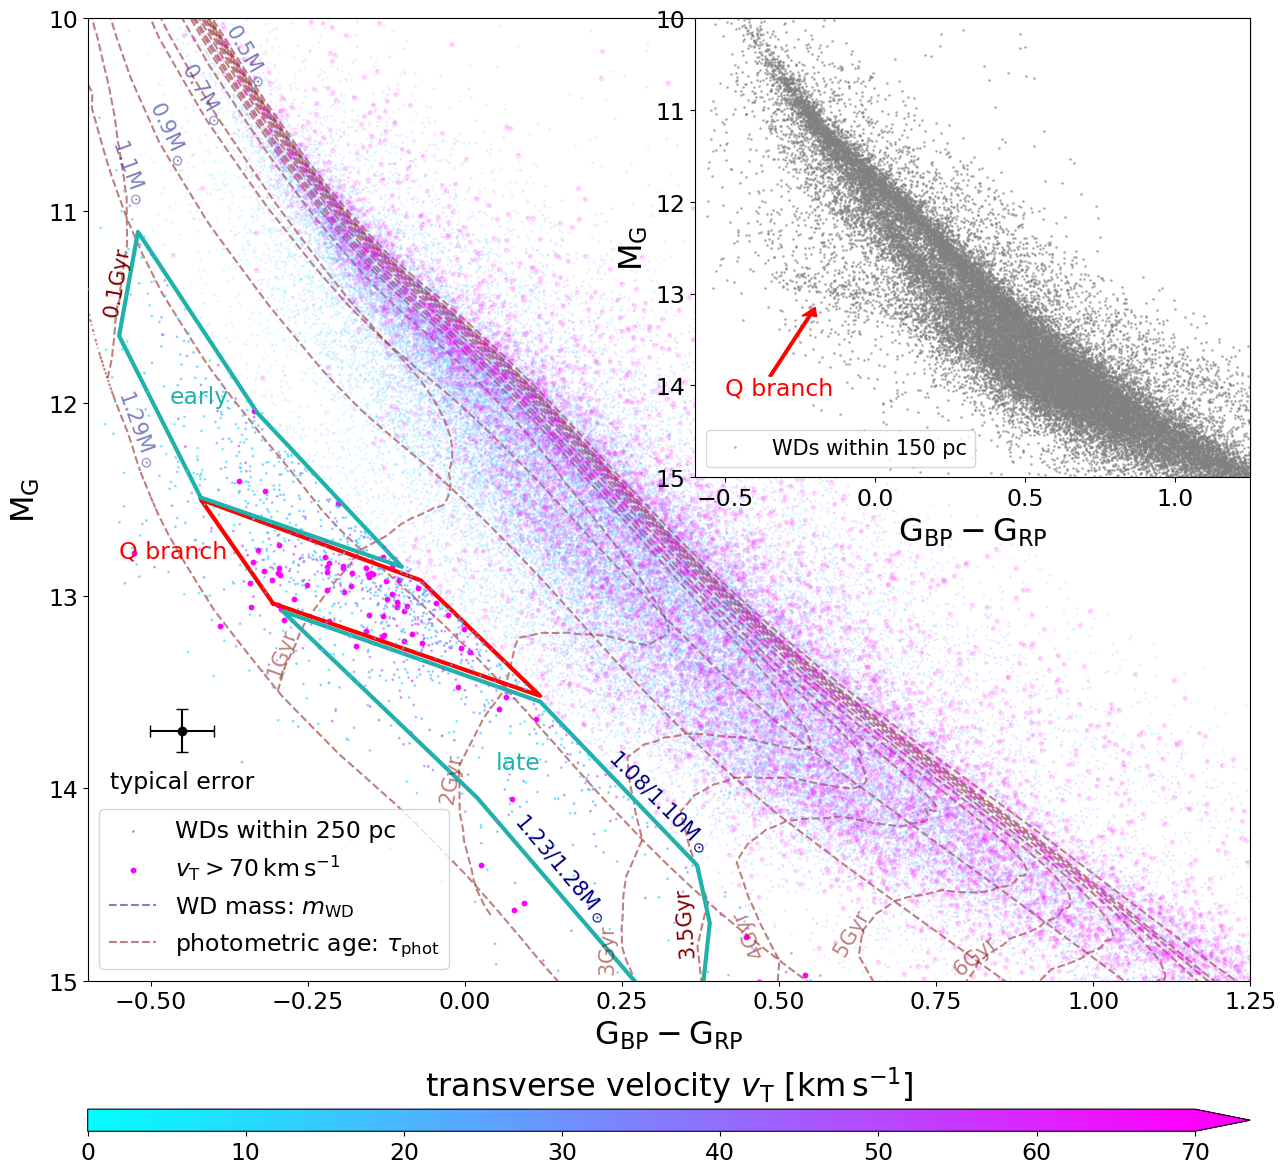

In [35]:
atm_type = 'H'
model = 'o'
WD_model = eval('model_'+atm_type+'_'+model)
mass_lim = 1.285#1.1#1.25
mass_min = 1.08#0.9#1.08

GRID, REGIONS, BINARY, BOX, POSTER = [True, True, False, False, False]

tick_size = 17#21#17#15
label_size = 23#25#23#17
title_size = 23#25#23#17
text_size = 15#21#15
size_excess = 2#4
plt.rc('ytick', labelsize=tick_size)
plt.rc('xtick', labelsize=tick_size) 
plt.rc('font', family='Helvitica', size=label_size) 
plt.rc('axes', labelsize=label_size)
plt.rc('legend', fontsize=label_size)
plt.rc('figure', titlesize=title_size)

WD = WD_warwick[WD_250].copy()

WD['bp_rp_error'] = ((WD['phot_bp_mean_flux_error']/WD['phot_bp_mean_flux'])**2+\
                               (WD['phot_rp_mean_flux_error']/WD['phot_rp_mean_flux'])**2)**0.5
WD['G_error'] = WD['parallax_error'] / WD['parallax'] * 2

v_max = 70
D2 = 250
plt.figure(figsize=(15,17),dpi=100)
plot_HR_1(WD, WD['bp_rp'], WD['G'], WD['bp_rp_error'], WD['G_error'], 'cool',
          0, D2, alpha_lowmass=0.1 )
plt.xlim(-0.6,1.25); plt.xlabel('$\\rm{G_{BP} - G_{RP}}$');
plt.ylim(15,10); plt.ylabel('$\\rm{M_G}$');

WD_early_late, WD_Q, high_mass_numbers, _ = number_of_branch(WD,D2,70)
plt.errorbar([-0.45],[13.7],
             xerr=vstack((WD_early_late, WD_Q))['bp_rp_error'].mean(), 
             yerr=vstack((WD_early_late, WD_Q))['G_error'].mean(),
             color='k', fmt='o', capsize=4)
plt.text(-0.45, 14, 'typical error', fontsize=text_size+size_excess,
        horizontalalignment='center',)


a = plt.axes([0.53, 0.61, 0.37, 0.27],)
plot_HR(WD, WD['bp_rp'], WD['G'], WD['bp_rp_error'], WD['G_error'],
          0, 150,0.5, plot_arrow=True )
plt.xlim(-0.6,1.25);plt.xlabel('$\\rm{G_{BP} - G_{RP}}$');
plt.ylim(15,10);plt.ylabel('$\\rm{M_G}$');
WD_early_late, WD_Q, high_mass_numbers, _ = number_of_branch(WD,100,70)

plt.show()

# Figure 2

/Users/scheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater_equal
/Users/scheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in less
/Users/scheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in greater_equal
/Users/scheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in less
/Users/scheng/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
/Users/scheng/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
/Users/scheng/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Helve

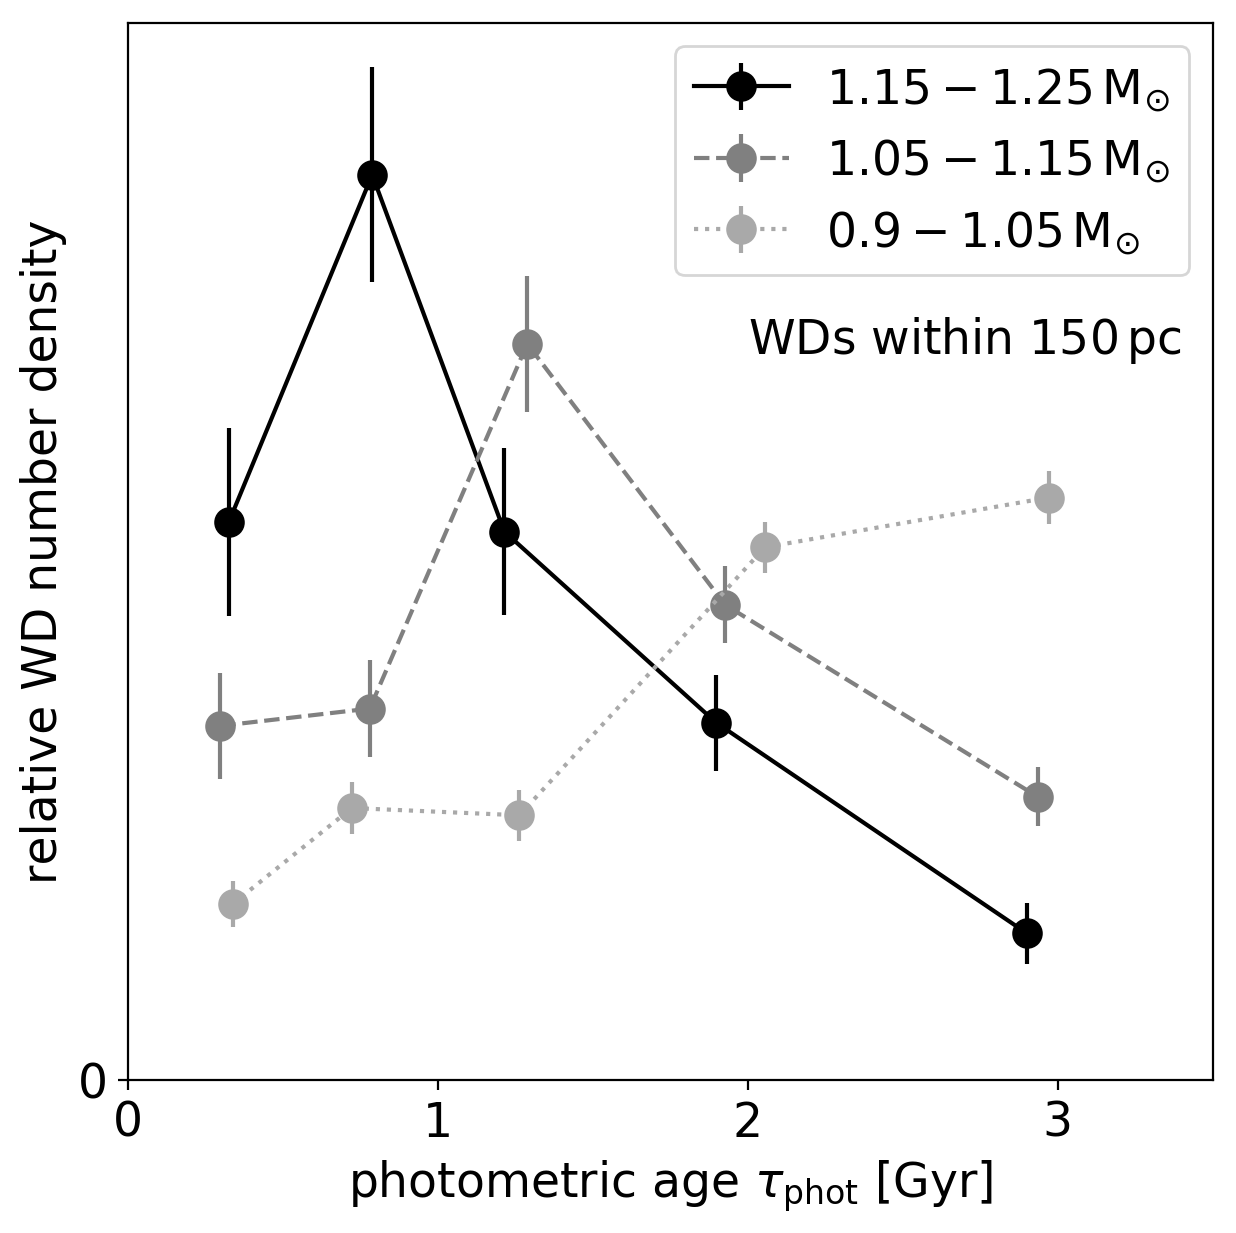

In [36]:
tick_size = 17#15
label_size = 17#17
title_size = 17#17
plt.rc('ytick', labelsize=tick_size) 
plt.rc('xtick', labelsize=tick_size) 
plt.rc('font', family='Helvetica', size=label_size) 
plt.rc('axes', labelsize=label_size)
plt.rc('legend', fontsize=label_size)
plt.rc('figure', titlesize=title_size)

WD = WD_warwick[WD_150].copy()# WD_MCMC_func.select_WD(WD_warwick,1.4,0.10,2,22,8,150)
atm_type = 'H'
model = 'o'

plt.figure(figsize=(7,7),dpi=200)
age_list = np.array([0.1,0.5,1,1.5,2.5,3.5])
interval = age_list[1:] - age_list[:-1]
mass_list = [1.25, 1.15, 1.05, 0.90]
linestyle = ['solid', 'dashed', 'dotted',]
color_list = ['k','gray','darkgray']
label = ['$1.15-1.25{\\rm\\,M_{\odot}}$', '$1.05-1.15{\\rm \\,M_{\odot}}$',
        '$0.9-1.05{\\rm\\,M_{\odot}}$']
for i in range(len(mass_list)-1):
    M0911 = (np.array(WD['mass_'+atm_type+'_'+model])>=mass_list[i+1]) *\
            (np.array(WD['mass_'+atm_type+'_'+model])<mass_list[i])
    histo = np.zeros(len(age_list)-1)
    age_mean = np.zeros(len(age_list)-1)
    for j in range(len(age_list)-1):
        age_select = (np.array(WD['age_'+atm_type+'_'+model])>=age_list[j])*\
                     (np.array(WD['age_'+atm_type+'_'+model])<age_list[j+1])
        histo[j] = (M0911*age_select).sum()
        age_mean[j] = WD['age_'+atm_type+'_'+model][M0911*age_select].mean()
    plt.errorbar(age_mean,histo/histo.sum()/interval*3.4,yerr=histo**0.5/histo.sum()/interval*3.4,
          color=color_list[i],linestyle=linestyle[i],label=label[i],marker='o',ms=10)   

nearby = 1/MWDD_warwick['parallax']*1000 < 150
mass_select = (MWDD_warwick['mass_H_o'] > 0.7) * (MWDD_warwick['mass_H_o'] < 0.9)
WD = MWDD_warwick[DA*nearby*mass_select]

histo = np.zeros(len(age_list)-1)
age_mean = np.zeros(len(age_list)-1)
for j in range(len(age_list)-1):
    age_select = (np.array(WD['age_'+atm_type+'_'+model])>=age_list[j])*\
                 (np.array(WD['age_'+atm_type+'_'+model])<age_list[j+1])
    histo[j] = (age_select).sum()
    age_mean[j] = WD['age_'+atm_type+'_'+model][age_select].mean()
# plt.errorbar(age_mean,histo/histo.sum()/interval*3.4,yerr=histo**0.5/histo.sum()/interval*3.4,
#      linestyle='dotted',label='$0.7-0.9{\\rm\\,M_{\odot}, DA}$',marker='o',ms=10)

plt.legend(loc=1)
plt.text(2,1.7,'WDs within $150{\\rm\,pc}$')
plt.xlim(0,3.5);plt.xlabel('photometric age $\\tau_{\\rm phot}$ [Gyr]'); plt.xticks([0,1,2,3])
plt.ylabel('relative WD number density')
plt.yticks([0])
plt.ylim(0.0)
plt.show()

# Table 2

In [28]:
small_d = (MWDD['Gaia_d']<4)
_ = number_of_branch(MWDD_warwick[small_d*DQ], 250, 70)

/Users/scheng/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
/Users/scheng/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


length of WD:  14 length of WD_Q:  21
after selection:
length of WD+WD_Q:  35
length of early:  11 length of WD_Q:  21 length of late:  3
fast: early: 1 Q:  4 late:  2


# Figure 3

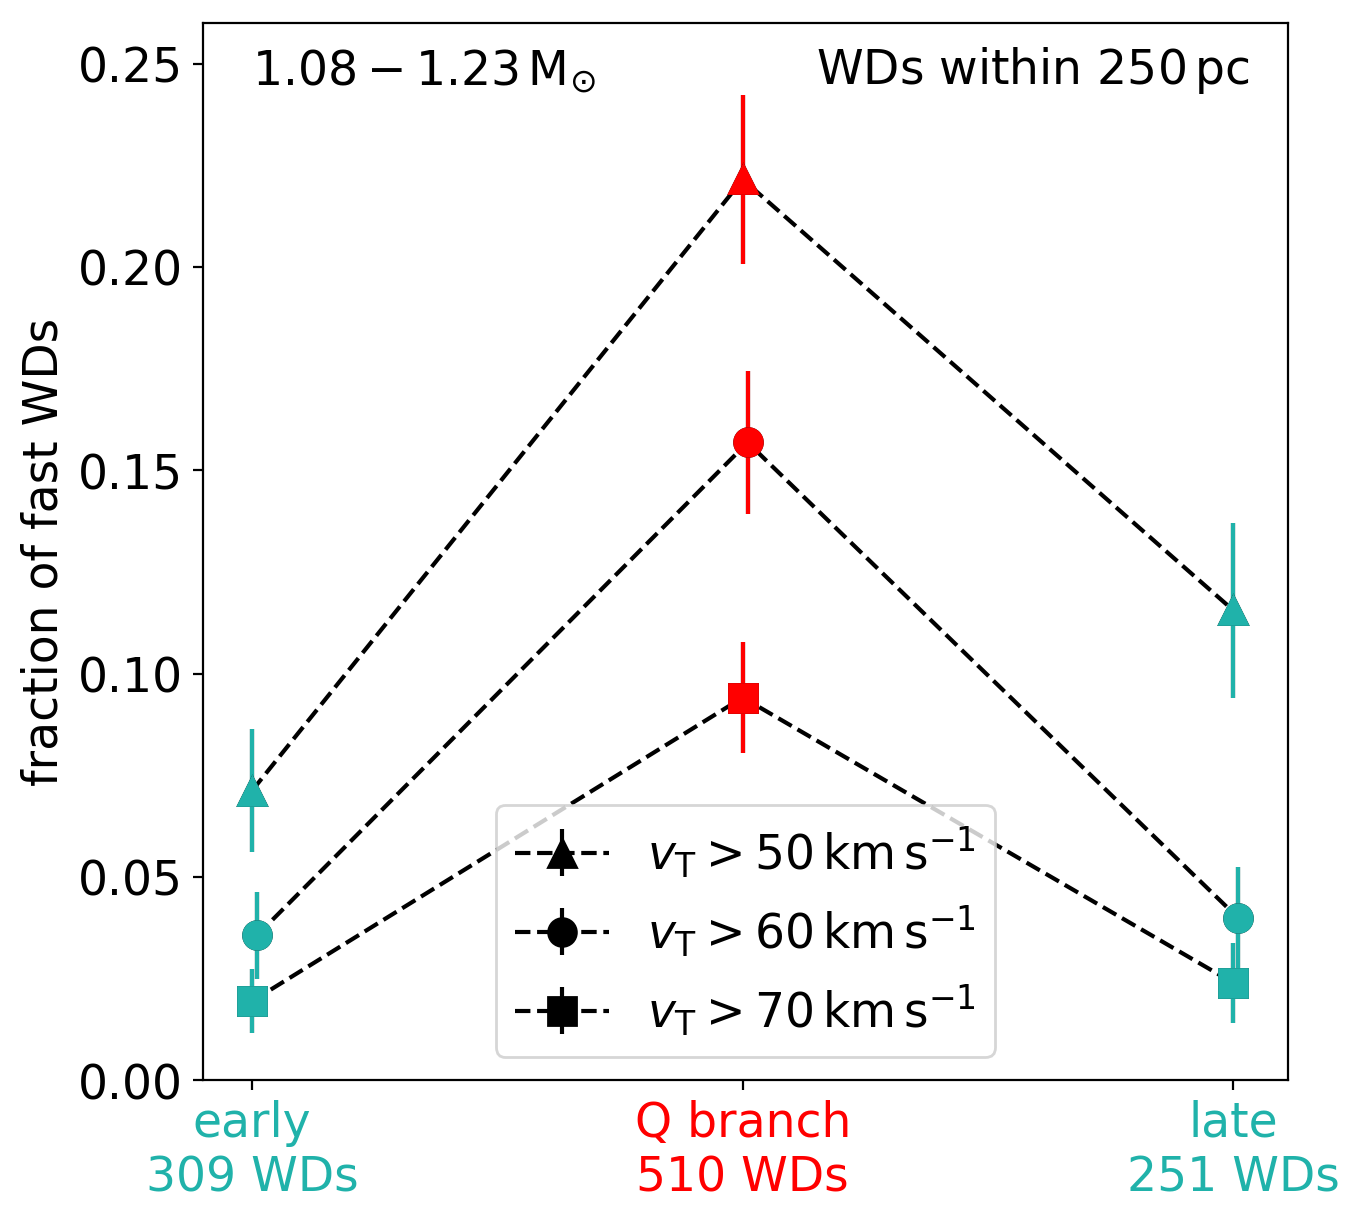

In [38]:
tick_size = 17#15
label_size = 17#17
title_size = 17#17
plt.rc('ytick', labelsize=tick_size) 
plt.rc('xtick', labelsize=tick_size) 
plt.rc('font', family='Helvetica', size=label_size) 
plt.rc('axes', labelsize=label_size)
plt.rc('legend', fontsize=label_size)
plt.rc('figure', titlesize=title_size)

plt.figure(figsize=(7,7),dpi=200)
# total = np.array([304,510,252])
total = np.array([309,510,251])
fast_tail = np.array([[22, 113, 29],[11,80,10],[6,48,6]]) #50km/s, 60km/s, 70km/s
color_list = ['lightseagreen','r','lightseagreen']
marker_list = ['^','o','s']
label_list = ['$v_{\\rm T}>50{\\rm\,km\,s^{-1}}$', '$v_{\\rm T}>60{\\rm\,km\,s^{-1}}$', 
              '$v_{\\rm T}>70{\\rm\,km\,s^{-1}}$']
x_offset = [0,0.01,0]


ax = plt.subplot(111)
for i in range(3):
    plt.errorbar([1+x_offset[i],2+x_offset[i],3+x_offset[i]],fast_tail[i]/total,yerr=fast_tail[i]**0.5/total,
             label=label_list[i],\
         c='k',marker=marker_list[i],ls='dashed',ms=10)

for i in range(3):
    for j in range(3):
        plt.errorbar([i+1+x_offset[j]],fast_tail[j,i]/total[i],yerr=fast_tail[j,i]**0.5/total[i],
         c=color_list[i],fmt=marker_list[j],ms=10,)

plt.legend(loc='lower center')

plt.ylabel('fraction of fast WDs')
plt.xticks((1,2,3), ('early\n'+str(total[0])+' WDs','Q branch\n'+str(total[1])+' WDs',
                     'late\n'+str(total[2])+' WDs'))
xticks = ax.get_xticklabels()
for i in range(3):
    xticks[i].set_color(color_list[i])
plt.ylim(0,0.26)

#plt.text(1,0.245,'$1.08<m_{\\rm WD}/M_{\odot}<1.23$')
plt.text(1,0.245,'$1.08-1.23\\,{\\rm M_{\odot}}$')
plt.text(2.15,0.245,'WDs within $250{\\rm\,pc}$')

plt.show()

/Users/scheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in less
/Users/scheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in greater
/Users/scheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater
/Users/scheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in less
/Users/scheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in greater
/Users/scheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in less


84
151
162


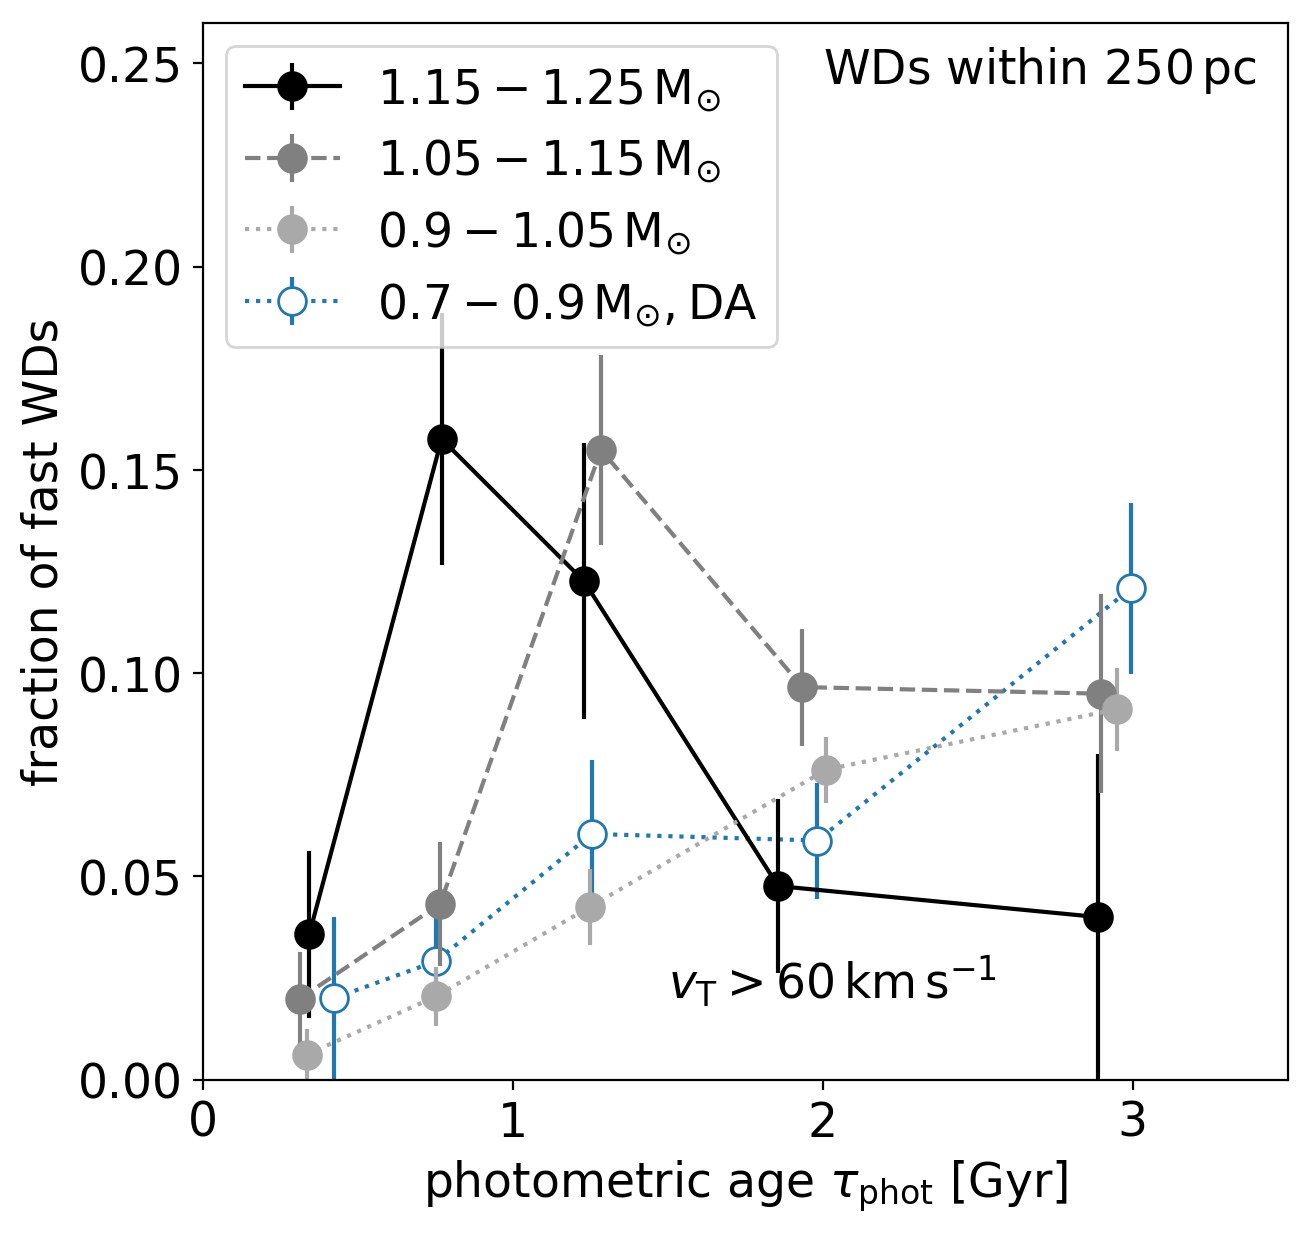

/Users/scheng/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
/Users/scheng/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


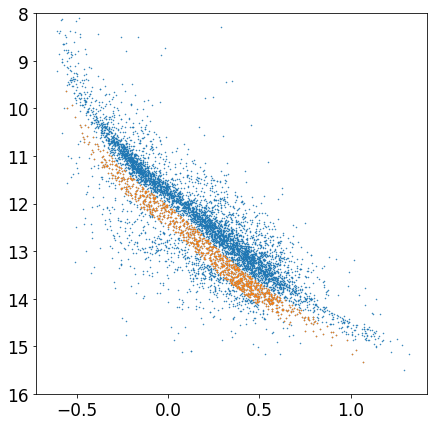

In [39]:
tick_size = 17#15
label_size = 17#17
title_size = 17#17
plt.rc('ytick', labelsize=tick_size) 
plt.rc('xtick', labelsize=tick_size) 
plt.rc('font', family='Helvetica', size=label_size) 
plt.rc('axes', labelsize=label_size)
plt.rc('legend', fontsize=label_size)
plt.rc('figure', titlesize=title_size)

WD = WD_warwick[WD_250].copy()
nearby = 1/MWDD_warwick['parallax']*1000 < 250
# WD = MWDD_warwick[DA*small_d*nearby]

atm_type = 'H'
model = 'o'

plt.figure(figsize=(7,7),dpi=200)
mass_list = [1.25, 1.15, 1.05, 0.90]
line_style = ['solid','dashed','dotted']
label = ['$1.15<m_{\\rm WD}/M_{\odot}<1.30$', '$1.05<m_{\\rm WD}/M_{\odot}<1.15$',
        '$0.90<m_{\\rm WD}/M_{\odot}<1.05$']
label = ['$1.15-1.25{\\rm \\,M_{\odot}}$', '$1.05-1.15{\\rm \\,M_{\odot}}$',
        '$0.9-1.05{\\rm \\,M_{\odot}}$']
color_list = ['k','gray','darkgray']
for j in range(len(mass_list)-1):
    M0911 = (np.array(WD['mass_'+atm_type+'_'+model])<mass_list[j]) * \
            (np.array(WD['mass_'+atm_type+'_'+model])>mass_list[j+1])
    points = []
    errors = []
    age_mean = []
    age_list = [0.1,0.5,1,1.5,2.5,3.5,]
    print(((np.array(WD['age_'+atm_type+'_'+model])>0.1)*(np.array(WD['age_'+atm_type+'_'+model])<0.5)*M0911).sum())
    for i in range(len(age_list)-1):
        fast = (np.array(WD['v'])>60)
        select_age = (np.array(WD['age_'+atm_type+'_'+model])>age_list[i]) * M0911 *\
        (np.array(WD['age_'+atm_type+'_'+model])<age_list[i+1])
        y_point = (fast*select_age).sum()/select_age.sum()
        y_error = (fast*select_age).sum()**0.5/select_age.sum() 
        if (fast*select_age).sum()<1 or ((fast*select_age).sum()<7 and i>4):
            y_point = ((fast*select_age).sum()+1)/select_age.sum()
            y_error = ((fast*select_age).sum()+1)**0.5/select_age.sum() 
        points.append( y_point )
        errors.append( y_error )
        age_mean.append( WD['age_'+atm_type+'_'+model][select_age].mean() )
    plt.errorbar(age_mean, points, yerr=errors, 
                 label=label[j],color=color_list[j],
                 linestyle=line_style[j],marker='o',ms=10)

plt.text(1.5,0.02,'$v_{\\rm T}>60{\\rm\,km\,s^{-1}}$')
plt.text(2,0.245,'WDs within $250{\\rm\,pc}$')
plt.legend(loc=2)
plt.xticks([0,1,2,3,4])
plt.ylim(0,0.26)
plt.xlim(0,3.5)
plt.xlabel('photometric age $\\tau_{\\rm phot}$ [Gyr]')
plt.ylabel('fraction of fast WDs')
#plt.savefig('fast_WD_mass_jun5.eps',format='eps')

# DA as comparison
WD = MWDD_warwick[DA*nearby*mass_select]
points = []
errors = []
age_mean = []
age_list = [0.1,0.5,1,1.5,2.5,3.5]
for i in range(len(age_list)-1):
    fast = (np.array(WD['v'])>60)
    select_age = (np.array(WD['age_H_o'])>age_list[i]) * (np.array(WD['age_H_o'])<age_list[i+1])
    y_point = (fast*select_age).sum()/select_age.sum()
    y_error = (fast*select_age).sum()**0.5/select_age.sum() 
    if (fast*select_age).sum()<1 or ((fast*select_age).sum()<7 and i>4):
        y_point = ((fast*select_age).sum()+1)/select_age.sum()
        y_error = ((fast*select_age).sum()+1)**0.5/select_age.sum() 
    points.append( y_point )
    errors.append( y_error )
    age_mean.append( WD['age_H_o'][select_age].mean() )
plt.errorbar(age_mean, points, yerr=errors,
             fmt='o',mfc='w',ms=10,zorder=-1,linestyle='dotted',label='$0.7-0.9{\\rm \\,M_{\odot}, DA}$')
plt.legend(loc=2)

plt.show()

# plot the spectroscopic sample on the HR diagram
nearby = 1/MWDD_warwick['parallax']*1000 < 250
mass_select = (MWDD_warwick['mass_H_o'] > 0.7) * (MWDD_warwick['mass_H_o'] < 0.9)
plt.figure(figsize = (7,7))
plt.plot(MWDD_warwick['bp_rp'][DA*nearby],MWDD_warwick['G'][DA*nearby],'.',markersize=1)
plt.plot(MWDD_warwick['bp_rp'][DA*nearby*mass_select],MWDD_warwick['G'][DA*nearby*mass_select],'.',markersize=1)
plt.ylim(16,8)
plt.show()

# Figure 4

/Users/scheng/anaconda3/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:635: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/Users/scheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in less
/Users/scheng/Gaia/WD_HR.py:310: RuntimeWarning: invalid value encountered in less
  return (np.abs(offset+x*slope-y)<width) * (x>xmin) * (x<xmax)
/Users/scheng/Gaia/WD_HR.py:310: RuntimeWarning: invalid value encountered in greater
  return (np.abs(offset+x*slope-y)<width) * (x>xmin) * (x<xmax)


nan is: 0
nan is: 0
249
181
3919
207


/Users/scheng/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


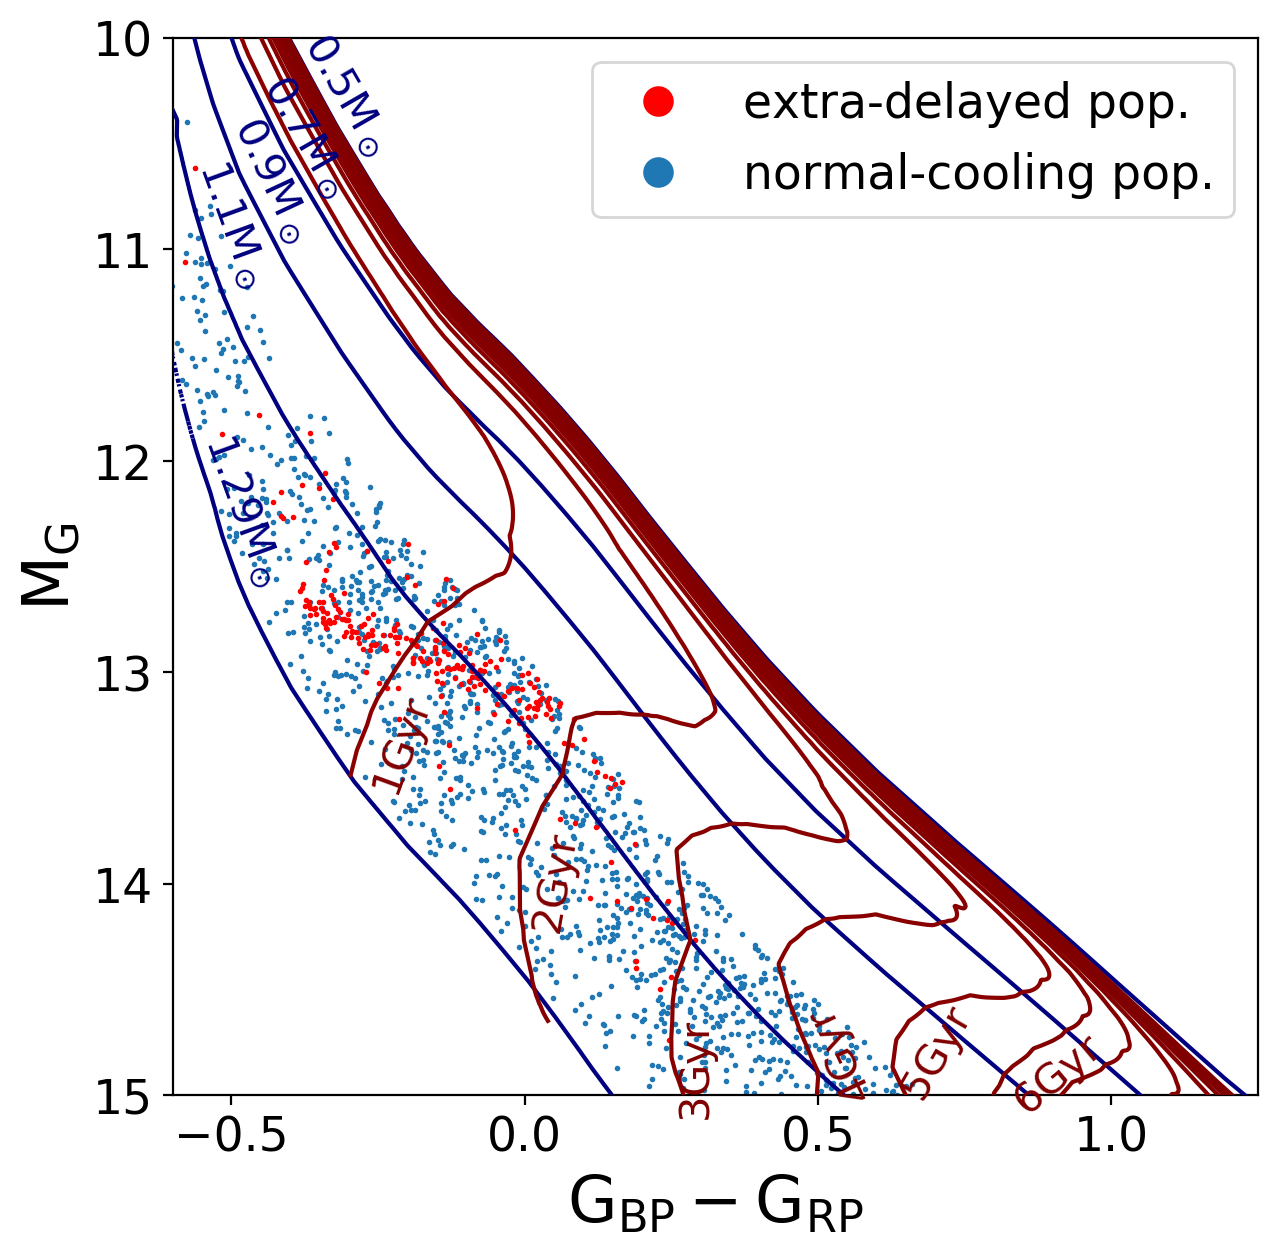

In [41]:
def generate_random_WD(N, age_lim=11, mass_min=0.9, mass_max=1.28, if_extra_delay=False, new_random=True,
                      age_Gyr=None, mass=None, age_step=None):
    if new_random==True:
        age_Gyr = np.random.uniform(0.01,age_lim,N)
        mass = np.random.uniform(mass_min,mass_max,N)
    else:
        age_Gyr = age_Gyr + age_step - np.floor((age_Gyr + age_step - 0.01)/(age_lim-0.01))*(age_lim-0.01)
    bprp = color_func(mass,age_Gyr)
    G = Mag_func(mass,age_Gyr) 
    center=0
    width=0
    if if_extra_delay==True:
        temp_x = np.arange(-0.5,0.6,0.01)
        temp_y2 = temp_x *1.2+ 13.2
        temp_y1 = temp_x *1+ 13.0
        age_Gyr_line1 = WD_model['HR_to_age'](temp_x, temp_y1)
        age_Gyr_line2 = WD_model['HR_to_age'](temp_x, temp_y2)
        mass_line1 = WD_model['HR_to_mass'](temp_x, temp_y1)
        mass_line2 = WD_model['HR_to_mass'](temp_x, temp_y2)
        age_vs_mass_func1 = interp1d(mass_line1, age_Gyr_line1)
        age_vs_mass_func2 = interp1d(mass_line2, age_Gyr_line2)
        
        y = lambda x,alpha,center,delay,width: x-\
                         (1-width/delay)/alpha*np.log((1+np.exp(alpha*(x-center+0.5*(delay+width))))/\
                                                      (1+np.exp(alpha*(x-0.5*(delay+width)-center))))
        alpha = 2
        delay = 8
        width = (age_vs_mass_func2(mass)-age_vs_mass_func1(mass))
        center = (age_vs_mass_func1(mass)+age_vs_mass_func2(mass))/2 + (delay)/2
        print('nan is: '+ str(np.isnan(age_vs_mass_func2(mass)).sum()))
        age_Gyr_delayed = y(age_Gyr, alpha, center, delay, width)
        bprp = color_func(mass,age_Gyr_delayed)
        G = Mag_func(mass,age_Gyr_delayed)             
    return bprp, G, age_Gyr, mass, center, width

spec_type = 'H'
model = 'o'
WD_model = eval('model_'+atm_type+'_'+model)
color_func = WD_models.interp_xy_z_func(x=WD_model['mass_array'],
                                        y=WD_model['age'],
                                        z=WD_model['color'],
                                        interp_type='linear')
Mag_func = WD_models.interp_xy_z_func(x=WD_model['mass_array'],
                                      y=WD_model['age'],
                                      z=WD_model['Mag'],
                                      interp_type='linear')

tick_size = 17#15
label_size = 23#17
title_size = 17#17
plt.rc('ytick', labelsize=tick_size) 
plt.rc('xtick', labelsize=tick_size) 
plt.rc('font', family='Helvetica', size=label_size) 
plt.rc('axes', labelsize=label_size)
plt.rc('legend', fontsize=label_size-2)
plt.rc('figure', titlesize=title_size)


N_S = 3928#1785#3928
N_E = 250#600
step = 0.1
AGE = False
bprp_sim_S, G_sim_S, age_sim_S, mass_sim_S,_,_ = generate_random_WD(N_S, age_lim=11, mass_min=1.05,
                                                                    if_extra_delay=False)
bprp_sim_E, G_sim_E, age_sim_E, mass_sim_E,_,_ = generate_random_WD(N_E, age_lim=11, mass_min=1.05,
                                                                    if_extra_delay=True,
                                                                    mass_max=1.23)
for i in range(1):  ####################### change this into 110 for animation
    bprp_sim_S, G_sim_S, age_sim_S, mass_sim_S,_,_ = generate_random_WD(N_S, age_lim=11, if_extra_delay=False,
                                                                        mass_min=1.05,
                                                                   new_random=False, age_Gyr=age_sim_S,
                                                                    mass=mass_sim_S, age_step=step)
    bprp_sim_E, G_sim_E, age_sim_E, mass_sim_E,_,_ = generate_random_WD(N_E, age_lim=11, if_extra_delay=True,
                                                                        mass_max=1.23, mass_min=1.05,
                                                                   new_random=False, age_Gyr=age_sim_E,
                                                                    mass=mass_sim_E, age_step=step)


    bprp_sim = np.concatenate((bprp_sim_S,bprp_sim_E))
    G_sim = np.concatenate((G_sim_S,G_sim_E))

    plt.figure(figsize=(7,7),dpi=200)
    if AGE==True:
        plot_HR(WD, np.concatenate((bprp_sim_E,bprp_sim_S)), np.concatenate((G_sim_E,G_sim_S)),
          0.01, 0.01,
          0, 150,1, grid=True, if_select=False, legend_on=False, plot_arrow=False,
           age=np.concatenate((age_sim_E, age_sim_S)), 
            age_colorbar_param={'pad':-1, 'aspect':10,'shrink':0.5, 'fraction':1,'anchor':(10,1),'panchor':False,
                            'extend':'max','ticks':(0,2,4,6)}, )
        plt.text(0.1, 11.5, 
          'An 8-Gyr extra cooling delay\ncan also explain the distribu-\ntion of true age and velocity\n        on the Q branch.',
                 fontsize=15) #age
        plt.text(0.8, 10.45, 'True age\n(Gyr)', fontsize=15)
        
    else:
        color = ['C0','r']
        #color = ['gray', 'gray']
        plot_HR([], bprp_sim_E, G_sim_E,
              0.01, 0.01,
              0, 0,1, color=color[1], grid=True, if_select=False, legend_on=False, plot_arrow=False,
               gif_legend='extra-delayed pop.', zorder=1)
        plot_HR([], bprp_sim_S, G_sim_S,
              0.01, 0.01,
              0, 0,1, color=color[0], grid=False, if_select=False, legend_on=False, plot_arrow=False,
                gif_legend='normal-cooling pop.' , zorder=0)
    plt.xlim(-0.6,1.25);plt.xlabel('$\\rm{G_{BP} - G_{RP}}$');
    plt.ylim(15,10);plt.ylabel('$\\rm{M_G}$');
    
#     plt.text(0.5, 12.5, 'frame step = 0.1 Gyr\nframe rate = 10 / s', fontsize=13)
#     plt.title('cooling of high-mass white dwarfs',fontsize=17)
    plt.savefig('talk_gif/'+str(i)+'.png')
    plt.show()

In [ ]:
from PIL import Image
im = Image.open('talk_gif/'+str(0)+'.png')
images=[]
for i in range(110):
    images.append(Image.open('talk_gif/'+str(i)+'.png'))
im.save('talk_gif/gif_two_pops.gif', save_all=True, append_images=images,loop=20,duration=100,comment=b"aaabb",
       )

# Talk GIF

/Users/scheng/anaconda3/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:635: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/Users/scheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in less
/Users/scheng/Gaia/WD_HR.py:310: RuntimeWarning: invalid value encountered in less
  return (np.abs(offset+x*slope-y)<width) * (x>xmin) * (x<xmax)
/Users/scheng/Gaia/WD_HR.py:310: RuntimeWarning: invalid value encountered in greater
  return (np.abs(offset+x*slope-y)<width) * (x>xmin) * (x<xmax)
/Users/scheng/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes 

nan is: 0
nan is: 0
4153
376


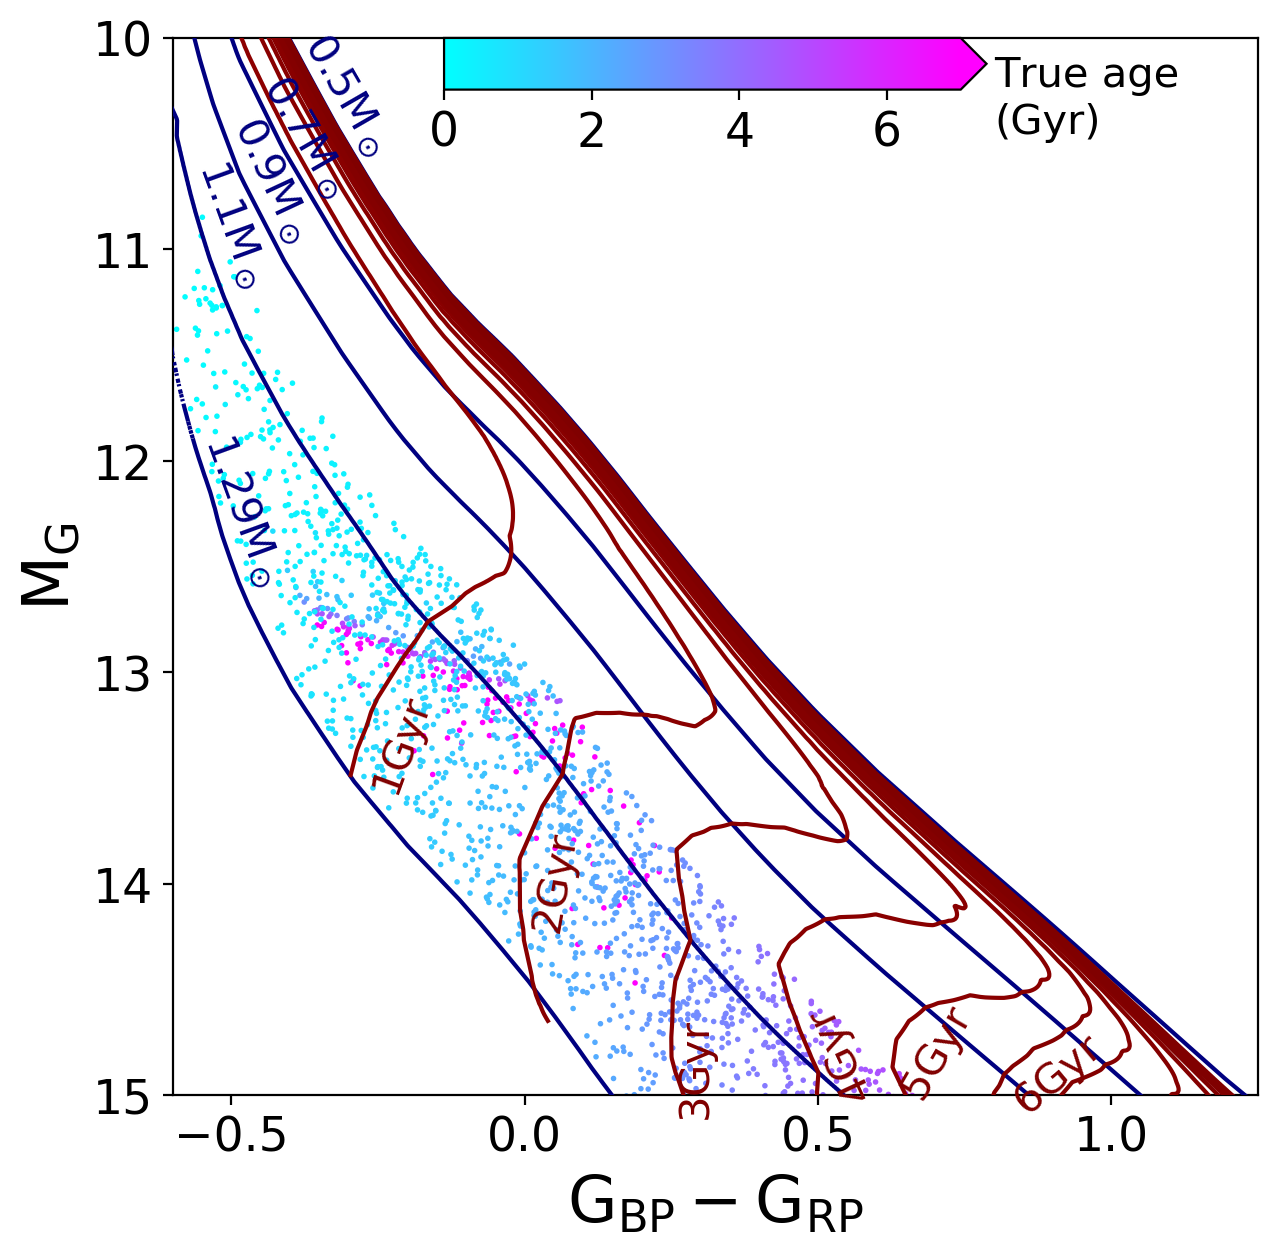

In [74]:
tick_size = 17#15
label_size = 23#17
title_size = 17#17
plt.rc('ytick', labelsize=tick_size) 
plt.rc('xtick', labelsize=tick_size) 
plt.rc('font', family='Helvetica', size=label_size) 
plt.rc('axes', labelsize=label_size)
plt.rc('legend', fontsize=label_size-2)
plt.rc('figure', titlesize=title_size)


N_S = 3928#1785#3928
N_E = 250#600
step = 0.1
AGE = True
bprp_sim_S, G_sim_S, age_sim_S, mass_sim_S,_,_ = generate_random_WD(N_S, age_lim=11, mass_min=1.05,
                                                                    if_extra_delay=False)
bprp_sim_E, G_sim_E, age_sim_E, mass_sim_E,_,_ = generate_random_WD(N_E, age_lim=11, mass_min=1.05,
                                                                    if_extra_delay=True,
                                                                    mass_max=1.23)
for i in range(1):  ####################### change this into 110 for animation
    bprp_sim_S, G_sim_S, age_sim_S, mass_sim_S,_,_ = generate_random_WD(N_S, age_lim=11, if_extra_delay=False,
                                                                        mass_min=1.05,
                                                                   new_random=False, age_Gyr=age_sim_S,
                                                                    mass=mass_sim_S, age_step=step)
    bprp_sim_E, G_sim_E, age_sim_E, mass_sim_E,_,_ = generate_random_WD(N_E, age_lim=11, if_extra_delay=True,
                                                                        mass_max=1.23, mass_min=1.05,
                                                                   new_random=False, age_Gyr=age_sim_E,
                                                                    mass=mass_sim_E, age_step=step)


    bprp_sim = np.concatenate((bprp_sim_S,bprp_sim_E))
    G_sim = np.concatenate((G_sim_S,G_sim_E))

    plt.figure(figsize=(7,7),dpi=200)
    if AGE==True:
        plot_HR([], np.concatenate((bprp_sim_E,bprp_sim_S)), np.concatenate((G_sim_E,G_sim_S)),
          0.01, 0.01,
          0, 150,1, grid=True, if_select=False, legend_on=False, plot_arrow=False,
           age=np.concatenate((age_sim_E, age_sim_S)), 
            age_colorbar_param={'pad':-1, 'aspect':10,'shrink':0.5, 'fraction':1,'anchor':(10,1),'panchor':False,
                            'extend':'max','ticks':(0,2,4,6)}, )
#         plt.text(0.1, 11.5, 
#           'An 8-Gyr extra cooling delay\ncan also explain the distribu-\ntion of true age and velocity\n        on the Q branch.',
#                  fontsize=15) #age
        plt.text(0.8, 10.45, 'True age\n(Gyr)', fontsize=15)
        
    else:
        color = ['C0','r']
        plot_HR([], bprp_sim_E, G_sim_E,
              0.01, 0.01,
              0, 0,1, color=color[1], grid=True, if_select=False, legend_on=False, plot_arrow=False,
               gif_legend='extra-delayed pop.', zorder=1)
        
#         color = ['C0','r']
#         plot_HR([], bprp_sim_S, G_sim_S,
#               0.01, 0.01,
#               0, 0,1, color=color[0], grid=True, if_select=False, legend_on=False, plot_arrow=False,
#                 gif_legend='normal-cooling pop.' , zorder=0)
        
#         color = ['gray', 'gray']
#         plot_HR([], np.concatenate((bprp_sim_E, bprp_sim_S)), np.concatenate((G_sim_E, G_sim_S)),
#               0.01, 0.01,
#               0, 0,1, color=color[1], grid=True, if_select=False, legend_on=False, plot_arrow=False,
#                gif_legend='both pop.', zorder=1)
        
        # or change the AGE setting above into True
    
    plt.xlim(-0.6,1.25);plt.xlabel('$\\rm{G_{BP} - G_{RP}}$');
    plt.ylim(15,10);plt.ylabel('$\\rm{M_G}$');
    #     plt.text(0.5, 12.5, 'frame step = 0.1 Gyr\nframe rate = 10 / s', fontsize=13)
    plt.savefig('talk_gif/'+str(i)+'.png')
    plt.show()

from PIL import Image
im = Image.open('talk_gif/'+str(0)+'.png')
images=[]

# for i in range(110):
#     images.append(Image.open('talk_gif/'+str(i)+'.png'))
# im.save('talk_gif/gif_extra_delayed_pop.gif', save_all=True, append_images=images,loop=20,duration=100,comment=b"aaabb",
#        )

# for i in range(110):
#     images.append(Image.open('talk_gif/'+str(i)+'.png'))
# im.save('talk_gif/gif_normal_pop.gif', save_all=True, append_images=images,loop=20,duration=100,comment=b"aaabb",
#        )

# for i in range(110):
#     images.append(Image.open('talk_gif/'+str(i)+'.png'))
# im.save('talk_gif/gif_both_pops.gif', save_all=True, append_images=images,loop=20,duration=100,comment=b"aaabb",
#        )

# for i in range(110):
#     images.append(Image.open('talk_gif/'+str(i)+'.png'))
# im.save('talk_gif/gif_age.gif', save_all=True, append_images=images,loop=20,duration=100,comment=b"aaabb",
#        )

# Figure 8

/Users/scheng/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
/Users/scheng/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


132489
Q_branch (no mass limit): 1551


/Users/scheng/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less_equal
  return getattr(self.data, op)(other)


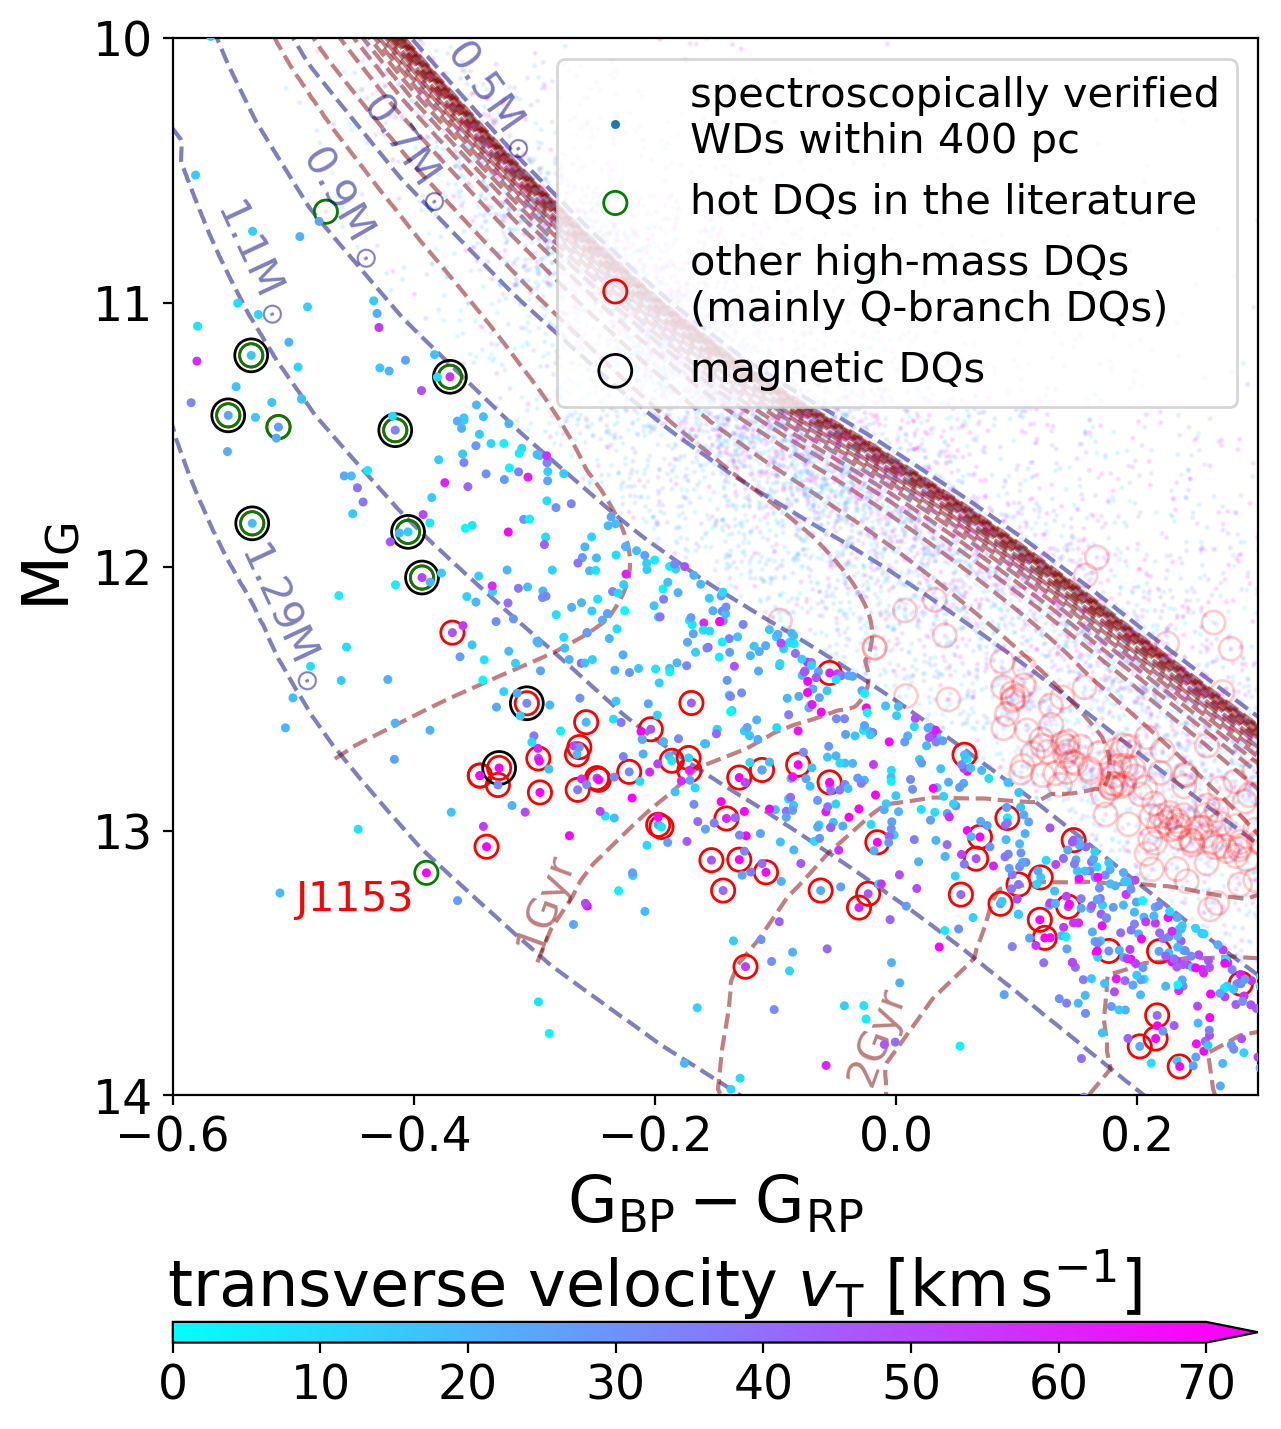

In [42]:
tick_size = 17#15
label_size = 23#17
title_size = 17#17
plt.rc('ytick', labelsize=tick_size) 
plt.rc('xtick', labelsize=tick_size) 
plt.rc('font', family='Helvetica', size=label_size) 
plt.rc('axes', labelsize=label_size)
plt.rc('legend', fontsize=label_size-2)
plt.rc('figure', titlesize=title_size)

atm_type = 'H'
model = 'o'
WD_model = eval('model_'+atm_type+'_'+model)
mass_lim = 1.5
mass_min = 0.9
d2 = 400#150

WD = WD_warwick[WD_400].copy()
WD['bp_rp_error'] = ((WD['phot_bp_mean_flux_error']/WD['phot_bp_mean_flux'])**2+\
                               (WD['phot_rp_mean_flux_error']/WD['phot_rp_mean_flux'])**2)**0.5
WD['G_error'] = WD['parallax_error'] / WD['parallax'] * 2

plt.figure(figsize=(7,10),dpi=200)
s1 = plot_HR_8(WD, WD['bp_rp'], WD['G'],
          WD['bp_rp_error'], WD['G_error'],'cool',
          0, d2 )
plt.xlim(-0.6,0.30);plt.xlabel('$\\rm{G_{BP} - G_{RP}}$');
plt.ylim(14,10);plt.ylabel('$\\rm{M_G}$');
plt.yticks([10,11,12,13,14])

# MWDD
d2 = 400#150
selection = DQ*near*(1/MWDD_warwick['parallax']*1000<d2)*(MWDD_warwick['mass_H_o']>0.9)
m1 = plt.scatter(MWDD_warwick['bp_rp'][selection],MWDD_warwick['G'][selection],s=70,c='',edgecolors='r',
            label='other high-mass DQs\n(mainly Q-branch DQs)')

selection = DQ*near*(1/MWDD_warwick['parallax']*1000<d2)*(MWDD_warwick['mass_H_o']<=0.9)
plt.scatter(MWDD_warwick['bp_rp'][selection],MWDD_warwick['G'][selection],s=70,c='',edgecolors='r',alpha=0.2)

selection = (ismag*(hotDQ_Dufour+DQ)+hotDQ_mag)*near*(1/MWDD_warwick['parallax']*1000<d2)*\
            (MWDD_warwick['mass_H_o']>0.9)
m2 = plt.scatter(MWDD_warwick['bp_rp'][selection],MWDD_warwick['G'][selection],s=140,c='',edgecolors='k',
            label='magnetic DQs',)

selection = hotDQ_Dufour*near*(1/MWDD_warwick['parallax']*1000<d2)
m3 = plt.scatter(MWDD_warwick['bp_rp'][selection],MWDD_warwick['G'][selection],s=70,c='',edgecolors='g',
            label='hot DQs in the literature')

plt.legend(handles=[s1,m3,m1,m2],loc=1,fontsize=15)
#plt.arrow(-0.55,13.5,0.1,-0.75,length_includes_head=True,
#              head_length=0.1,head_width=0.01,shape='full',overhang=0.1,width=0.01,
#             fc='r', ec='r',zorder=4)
plt.text(-0.5,13.3,'$\\rm J1153$',fontsize=15,color='r')
plt.show()

# Section 7.1: fraction of hot-DQs

In [44]:
# calculate the fraction of hot-DQs in the region where age<0.5Gyr, m>0.9Msun
d2 = 400
selection = (hotDQ_Dufour)*near*(1/MWDD_warwick['parallax']*1000<d2)*(MWDD_warwick['mass_H_o']>0.9)*\
                    (MWDD_warwick['age_H_o']>0.)*(MWDD_warwick['age_H_o']<0.5)
selection2 = ~CND*near*(1/MWDD_warwick['parallax']*1000<d2)*(MWDD_warwick['mass_H_o']>0.9)*\
                    (MWDD_warwick['age_H_o']>0.)*(MWDD_warwick['age_H_o']<0.5)
#MWDD_warwick[selection]
selection.sum(), selection2.sum(), selection.sum()/selection2.sum(), (selection.sum())**0.5/selection2.sum()

/Users/scheng/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
/Users/scheng/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


(8, 203, 0.039408866995073892, 0.013933138545547735)

# Figure 10

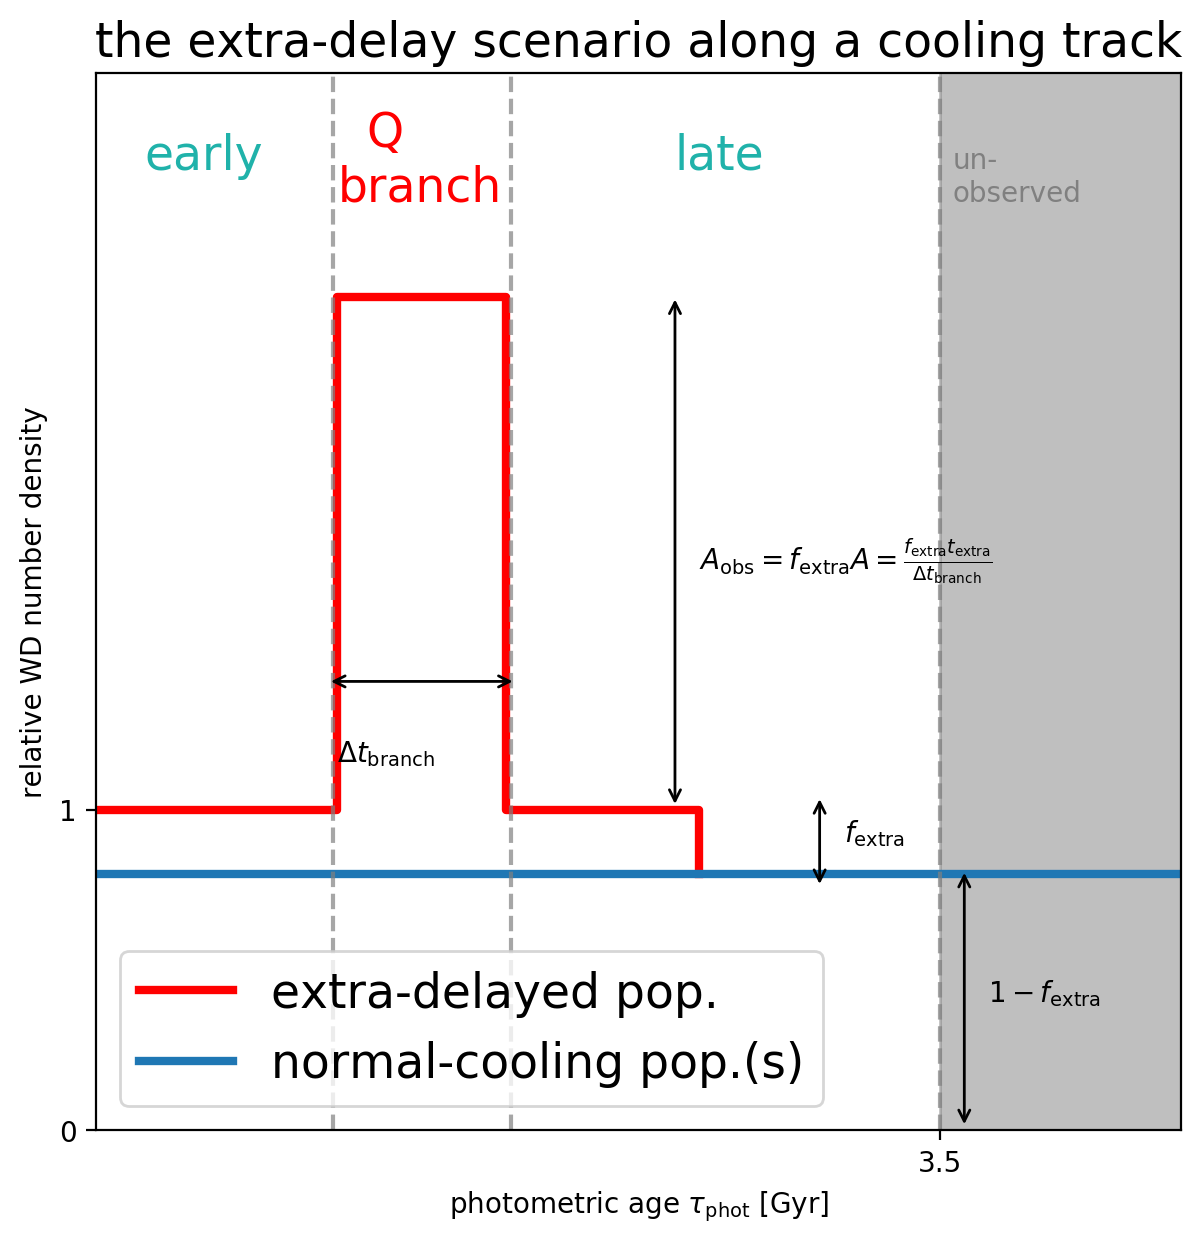

In [3]:
plt.figure(figsize=(7,7),dpi=200)
t0 = 1.0
t1 = 1.7
h = 2.6

plt.plot([0,t0,t0,t1,t1,2,2.5,2.5],[1,1,h,h,1,1,1,0.8],'r',lw=3,label='extra-delayed pop.')
plt.plot([0,5],[0.8,0.8],'C0',lw=3,label='normal-cooling pop.(s)')
plt.legend(loc=3,fontsize=17)

plt.axvline(t0-0.02,ls='dashed',alpha=0.7,c='grey')
plt.axvline(t1+0.02,ls='dashed',alpha=0.7,c='grey')
plt.axvline(3.5,ls='dashed',alpha=0.7,c='grey')
plt.fill([3.5,3.5,5,5],[0,4,4,0],color='grey',alpha=0.5,
         label='')

plt.text(0.2,3.0,'early',color='lightseagreen',fontsize=17)
plt.text(t0,2.9,'  Q\nbranch',color='r',fontsize=17)
plt.text(2.4,3.0,'late',color='lightseagreen',fontsize=17)
plt.text(3.55,2.9,'un-\nobserved',color='grey')

# 1-f_Q
plt.annotate("", xy=(3.6, 0), xycoords='data',
             xytext=(3.6, 0.82), textcoords='data',
             arrowprops=dict(arrowstyle="<->", connectionstyle="arc3"))
plt.text(3.7, 0.4, '$1-f_{\\rm extra}$')
         #{'color': 'k', 'fontsize': 24, 'ha': 'center', 'va': 'center',
        # 'bbox': dict(boxstyle="round", fc="w", ec="k", pad=0.2)})

# f_Q
plt.annotate("", xy=(3.0, 0.75), xycoords='data',
             xytext=(3.0, 1.05), textcoords='data',
             arrowprops=dict(arrowstyle="<->", connectionstyle="arc3"))
plt.text(3.1, 0.9, '$f_{\\rm extra}$')

# A_obs
plt.annotate("", xy=(2.4, 1), xycoords='data',
             xytext=(2.4, 2.61), textcoords='data',
             arrowprops=dict(arrowstyle="<->", connectionstyle="arc3"))
plt.text(2.5, 1.75, '$A_{\\rm obs}=f_{\\rm extra}A=\\frac{f_{\\rm extra}t_{\\rm extra}}{\Delta t_{\\rm branch}}$')

# t_delay
plt.annotate("", xy=(t0-0.05, 1.4), xycoords='data',
             xytext=(t1+0.05, 1.4), textcoords='data',
             arrowprops=dict(arrowstyle="<->", connectionstyle="arc3"))
plt.text(t0, 1.15, '$\Delta t_{\\rm branch}$')

# enhancement
#plt.annotate("Accumulation\ndue to\ncooling delay", xy=(1.05, 2.5), xycoords='data',
#             xytext=(0.05, 1.8), textcoords='data',color='darkorange',fontsize=13,
#             arrowprops=dict(arrowstyle="<-", connectionstyle="arc3",color='orange'))

plt.ylim(0,3.3)
plt.yticks([0,1])
plt.xticks([3.5])
plt.xlim(0,4.5)
plt.xlabel('photometric age $\\tau_{\\rm phot}$ [Gyr]')
plt.ylabel('relative WD number density')
plt.title('the extra-delay scenario along a cooling track',fontsize=17)
plt.show()

# Number of WDs in each region

In [29]:
_ = number_of_branch(WD_warwick[WD_250],250,70)

/Users/scheng/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
/Users/scheng/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


length of WD:  619 length of WD_Q:  510
after selection:
length of WD+WD_Q:  1070
length of early:  309 length of WD_Q:  510 length of late:  251
fast: early: 6 Q:  48 late:  6


# CSV files of the paper

In [34]:
# select WDs
WD = WD_warwick[WD_250].copy()
WD['bp_rp_error'] = ((WD['phot_bp_mean_flux_error']/WD['phot_bp_mean_flux'])**2 + 
                               (WD['phot_rp_mean_flux_error']/WD['phot_rp_mean_flux'])**2)**0.5
WD['G_error'] = WD['parallax_error'] / WD['parallax'] * 2
WD_early_late, WD_Q, high_mass_numbers, early, late, vL, vL_Q, vB, vB_Q = number_of_branch(WD,250,70)
print('total number:  '+str(high_mass_numbers))
print('mean bp-rp error:  '+str(vstack((WD_early_late, WD_Q))['bp_rp_error'].mean()) )
print('mean M_G error:  '+str(vstack((WD_early_late, WD_Q))['G_error'].mean()) )

/Users/scheng/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
/Users/scheng/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


length of WD:  619 length of WD_Q:  510
after selection:
length of WD+WD_Q:  1070
length of early:  309 length of WD_Q:  510 length of late:  251
fast: early: 6 Q:  48 late:  6
total number:  (1070, 309, 510, 251, 6, 48, 6)
mean bp-rp error:  0.0510847195345
mean M_G error:  0.111504957416


In [35]:
def get_vLvB_no_Oort(l,b,pml,pmb,factor,v_drift,U,V,W):
    vL = pml*factor+(V+v_drift)*np.cos(l/180*np.pi)-\
      U*np.sin(l/180*np.pi)
    vB = pmb*factor+W*np.cos(b/180*np.pi) -\
                ((V+v_drift)*np.sin(l/180*np.pi)+U*np.cos(l/180*np.pi))*np.sin(b/180*np.pi)
    return vL, vB

In [36]:
# write the csv tables
for table_original, table_final, vL_temp, vB_temp in [
    (WD_early_late[early].copy(), 'WD_early', vL[early], vB[early]),
    (WD_early_late[late].copy(), 'WD_late', vL[late], vB[late]),
    (WD_Q.copy(), 'WD_Q', vL_Q, vB_Q)]:
    
    vL_no_correction, vB_no_correction = get_vLvB_no_Oort(
        table_original['l'], table_original['b'],
        table_original['pml'], table_original['pmb'],
        table_original['factor'], table_original['l']*0,
        0,0,0)
    vL_paper, vB_paper = WD_MCMC_func.get_v_delayed_3D(
        None, table_original['l'], table_original['b'],
        table_original['pml'], table_original['pmb'],
        table_original['factor'], table_original['l']*0,
        0,0,0)
    vL_vsun_subtracted, vB_vsun_subtracted = get_vLvB_no_Oort(
        table_original['l'], table_original['b'],
        table_original['pml'], table_original['pmb'],
        table_original['factor'], table_original['l']*0,
        11,12,7)
    WD_paper = table_original['White_dwarf_name','source_id','ra','dec','parallax','parallax_error',
         'pmra','pmdec','astrometric_excess_noise','astrometric_sigma5d_max',
         'phot_g_mean_flux','phot_g_mean_flux_error',
                       'phot_g_mean_mag',
         'phot_bp_mean_flux','phot_bp_mean_flux_error',
                       'phot_bp_mean_mag',
         'phot_rp_mean_flux','phot_rp_mean_flux_error',
                       'phot_rp_mean_mag',
         'phot_bp_rp_excess_factor','l','b','bp_rp','G','bp_rp_error','G_error',
         'age_H_f','mass_H_f','age_H_o','mass_H_o','age_He_f','mass_He_f','age_He_o','mass_He_o']
    WD_paper.rename_column('G', 'M_G')
    WD_paper.rename_column('G_error', 'M_G_error')
    WD_paper['vL_no_correction'] = vL_no_correction
    WD_paper['vB_no_correction'] = vB_no_correction
    WD_paper['vL_paper'] = vL_paper # Oort
    WD_paper['vB_paper'] = vB_paper
    WD_paper['vL_vsun_subtracted'] = vL_vsun_subtracted # only solar motion substracte
    WD_paper['vB_vsun_subtracted'] = vB_vsun_subtracted
    WD_paper['vL_centered'] = vL_temp # Oort, asymmetric drift, solar
    WD_paper['vB_centered'] = vB_temp
    
    WD_paper['MWDD_spectype']=MWDD['spectype'][:len(WD_paper)]
    WD_paper['MWDD_wdid']=MWDD['wdid'][:len(WD_paper)]
    WD_paper['MWDD_wdname']=MWDD['wdname'][:len(WD_paper)]
    WD_paper['MWDD_ismag']=MWDD['ismag'][:len(WD_paper)]
    
    for i in range(len(WD_paper)):
        select = MWDD_warwick['source_id']==WD_paper[i]['source_id']
        gaia_d = MWDD[select]['Gaia_d']
        if select.sum()!=0:
            m = gaia_d.min()
            if m<4:
                for column in ['MWDD_wdid','MWDD_wdname','MWDD_spectype','MWDD_ismag']:
                    WD_paper[i][column] = MWDD[select][gaia_d==m][column[5:]][0]
            else:
                for column in ['MWDD_wdid','MWDD_wdname','MWDD_spectype','MWDD_ismag']:
                    WD_paper[i][column] = 'null'
        else:
            for column in ['MWDD_wdid','MWDD_wdname','MWDD_spectype','MWDD_ismag']:
                WD_paper[i][column] = 'null'
    WD_paper.sort('phot_g_mean_mag')
    exec( table_final +'_table = WD_paper' )
    exec( table_final +'_table.write(\''+table_final+'_paper.csv\', overwrite=True, format=\'csv\')')
    print(table_final +'_table.write(\''+table_final+'_paper.csv\', overwrite=True, format=\'csv\')')

WD_early_table.write('WD_early_paper.csv', overwrite=True, format='csv')
WD_late_table.write('WD_late_paper.csv', overwrite=True, format='csv')
WD_Q_table.write('WD_Q_paper.csv', overwrite=True, format='csv')


In [37]:
# combine the three regions
WD_early_table['region on HRD'] = 'E'
WD_Q_table['region on HRD'] = 'Q'
WD_late_table['region on HRD'] = 'L'
WD_table = vstack((WD_early_table,WD_Q_table,WD_late_table))
WD_table.write('WD_highmass_paper.csv', overwrite=True)

In [ ]:
# Check writing results
# WD_table.rename_column('ra','RAdeg')
# WD_table.rename_column('dec','DEdeg')
# WD_table.rename_column('l','GLON')
# WD_table.rename_column('b','GLAT')
# WD_table.rename_column('parallax','plx')
# WD_table.rename_column('parallax_error','e_plx')
# WD_table.rename_column('pmra','pmRA')
# WD_table.rename_column('pmdec','pmDE')
# Table.read('WD_highmass_paper.csv')

In [40]:
# load and check the table
WD_table = Table.read('WD_highmass_paper.csv')
WD_table[100]

<Row index=100>
   White_dwarf_name         source_id            ra           dec          parallax   parallax_error      pmra         pmdec     astrometric_excess_noise astrometric_sigma5d_max phot_g_mean_flux phot_g_mean_flux_error phot_g_mean_mag phot_bp_mean_flux phot_bp_mean_flux_error phot_bp_mean_mag phot_rp_mean_flux phot_rp_mean_flux_error phot_rp_mean_mag phot_bp_rp_excess_factor       l             b         bp_rp        M_G        bp_rp_error      M_G_error       age_H_f       mass_H_f      age_H_o        mass_H_o   age_He_f mass_He_f age_He_o mass_He_o vL_no_correction vB_no_correction    vL_paper      vB_paper    vL_vsun_subtracted vB_vsun_subtracted  vL_centered  vB_centered  MWDD_spectype MWDD_wdid MWDD_wdname MWDD_ismag region on HRD
        str22                 int64           float64       float64        float64       float64        float64       float64            float64                  float64             float64             float64             float64          float64              float64             float64           float64              float64             float64              float64             float64       float64     float64     float64        float64         float64        float64       float64       float64        float64    float64   float64  float64   float64      float64          float64         float64       float64          float64            float64          float64      float64        str10       str29      str11       str4         str1    
---------------------- ------------------- ------------- -------------- ------------- -------------- ------------- ------------- ------------------------ ----------------------- ---------------- ---------------------- --------------- ----------------- ----------------------- ---------------- ----------------- ----------------------- ---------------- ------------------------ ------------- ------------- --------- ------------- --------------- --------------- -------------- ------------ -------------- ------------- -------- --------- -------- --------- ---------------- ---------------- ------------- -------------- ------------------ ------------------ ------------- ------------ ------------- --------- ----------- ---------- -------------
WDJ082846.36-341638.85 5543590503156594048 127.193248758 -34.2775537752 6.44456371351 0.129794274824 12.2723081973 -22.002671061           0.256778494033              0.20826189    1045.98501643          1.72374172925       18.139551     917.417780212           8.18782498692        17.944971     373.991744219           11.0525982123        18.329765                1.2346349 254.018729571 2.64899896474 -0.384794 12.1855186083 0.0308712831221 0.0402802363649 0.318821950023 1.1962278768 0.347614725014 1.16423911216      nan       nan      nan       nan    18.4599706756   -2.12858915506 22.0539594973 -2.07475895783      25.7309625678      5.53707507475 28.5001385854 5.1406133205          null      null        null       null             E

/Users/scheng/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


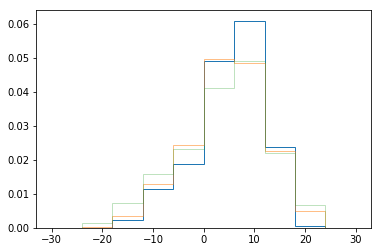

In [41]:
plt.hist((WD_table['vB_centered']-WD_table['vB_no_correction'])[WD_table['region on HRD']=='E'], 10, (-30,30),
        normed=True, histtype='step')
plt.hist((WD_table['vB_centered']-WD_table['vB_no_correction'])[WD_table['region on HRD']=='Q'], 10, (-30,30),
        alpha=0.5, normed=True,histtype='step')
plt.hist((WD_table['vB_centered']-WD_table['vB_no_correction'])[WD_table['region on HRD']=='L'], 10, (-30,30),
        alpha=0.3, normed=True, histtype='step')
plt.show()

In [21]:
WD_table = Table.read('WD_Q_paper.csv')
WD_table.sort('phot_bp_mean_mag')
WD_table['v'] = (WD_table['vL_centered']**2 + WD_table['vB_centered']**2)**0.5
WD_table['White_dwarf_name', 'source_id', 'ra', 'dec', 'phot_bp_mean_mag', 'v', 'parallax', 'MWDD_spectype'][100:120]

<Table length=20>
   White_dwarf_name         source_id      ...    parallax   MWDD_spectype
        str22                 int64        ...    float64         str5    
---------------------- ------------------- ... ------------- -------------
WDJ222551.23+410748.71 1957439488412516736 ... 9.60280255699          null
WDJ170429.64-394307.10 5967145849862816128 ... 9.18013799996          null
WDJ234933.31-232036.52 2339287644669893760 ... 8.58200818228          null
WDJ015245.89+301030.56  303996513900957440 ... 8.20670268398          null
WDJ041755.20-224548.30 4897604155986290432 ... 9.18869172853          null
WDJ133151.40+372755.15 1475194238223608064 ... 7.46580760166            DQ
WDJ141309.32+191831.83 1245989803779362432 ... 8.20908021961           DAH
WDJ041235.64+720603.44  501155892409974528 ... 8.88839970283          null
WDJ143840.65-284250.27 6221941997264505344 ... 9.16914851837          null
WDJ034557.00+301353.28  168143743391295488 ... 9.09247401915          null
WDJ131021.74+070027.31 3729853400616315648 ... 8.34321276518          null
WDJ1842310.0+201232.92 4530717367992861440 ... 7.66047070582          null
WDJ003024.69-481348.55 4975675911123806464 ... 9.08210959783          null
WDJ134520.20-070402.99 3620113245287620352 ... 7.97630019141          null
WDJ001337.05-031426.23 2445159756747426304 ... 7.63055847465          null
WDJ032521.11+254038.62  117261167051122688 ... 7.78972935467          null
WDJ221612.86+790855.45 2284371333830176640 ... 8.37361414054          null
WDJ173239.89+215450.71 4556745861930491136 ... 8.19046030653          null
WDJ140518.84-093247.51 3615080432674356992 ... 8.95107572572          null
WDJ112538.72-311247.73 3481710531219239296 ... 7.45631692322          null

# Talk Figures

/Users/scheng/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
/Users/scheng/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


32342
286


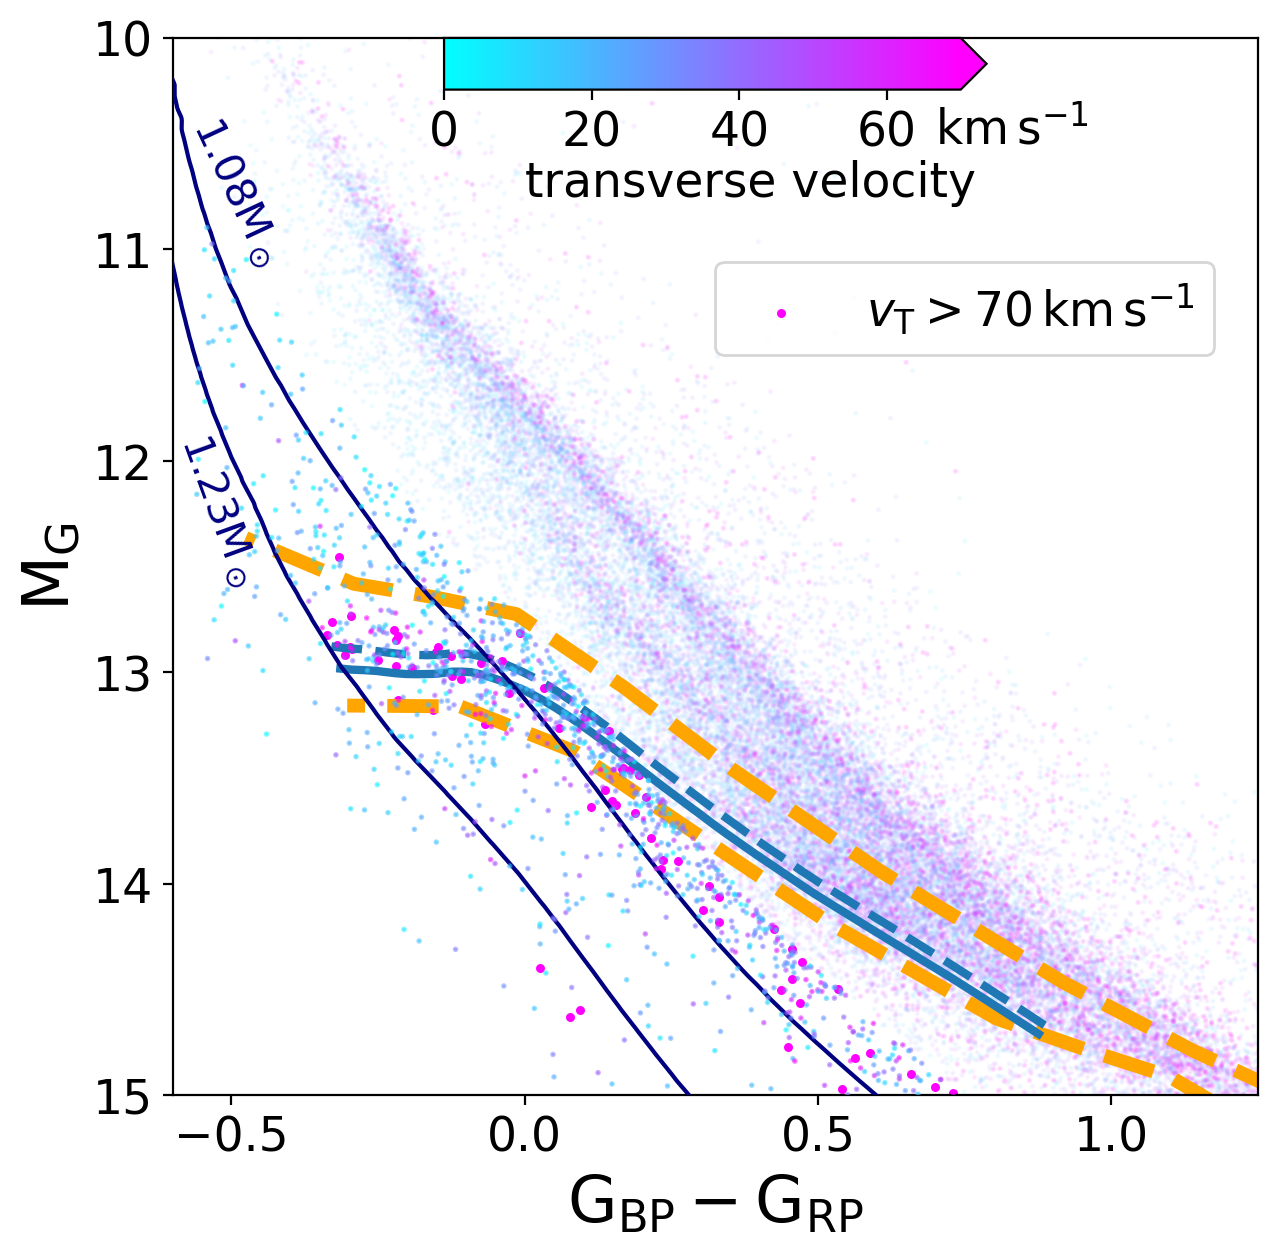

In [69]:
tick_size = 17#15
label_size = 23#17
title_size = 17#17
plt.rc('ytick', labelsize=tick_size) 
plt.rc('xtick', labelsize=tick_size) 
plt.rc('font', family='Helvetica', size=label_size) 
plt.rc('axes', labelsize=label_size)
plt.rc('legend', fontsize=label_size-2)
plt.rc('figure', titlesize=title_size)
text_size = 13#21#15
size_excess = 2#4

atm_type = 'H'
model = 'o'
WD_model = eval('model_'+atm_type+'_'+model)
v_max = 70
mass_min = 1.0

REGIONS = False
GRID = False

WD = WD_warwick[WD_250].copy()
WD['bp_rp_error'] = ((WD['phot_bp_mean_flux_error']/WD['phot_bp_mean_flux'])**2+\
                               (WD['phot_rp_mean_flux_error']/WD['phot_rp_mean_flux'])**2)**0.5
WD['G_error'] = WD['parallax_error'] / WD['parallax'] * 2

plt.figure(figsize=(7,7),dpi=200)
plot_HR_poster(WD, WD['bp_rp'], WD['G'], WD['bp_rp_error'], WD['G_error'],
               0, 150, alpha=1, color='gray',
               box=False, plot_arrow=False, colorbar_on=True, 
               alpha_lowmass=0.05, alpha_highmass=0.5, alpha_highfast=1, alpha_grid=0.5,
               legend_on=False,
          vel_colorbar_param={'pad':-1, 'aspect':10,'shrink':0.5, 'fraction':1,'anchor':(10,1),'panchor':False,
                            'extend':'max','ticks':(0,20,40,60)},
              one_grid=True)

# plot region of crystallization
plt.plot(c20[:,0],c20[:,1],'--',color='orange',lw=5)
plt.plot(c80[:,0],c80[:,1],'--',color='orange',lw=5)

plot_analytical(3.5, 'H')

plt.xlim(-0.6,1.25);plt.xlabel('$\\rm{G_{BP} - G_{RP}}$');
plt.ylim(15,10);plt.ylabel('$\\rm{M_G}$');
plt.show()

tick_size = 17#15
label_size = 17#17
title_size = 17#17
plt.rc('ytick', labelsize=tick_size)
plt.rc('xtick', labelsize=tick_size)
plt.rc('font', family='Helvetica', size=label_size) 
plt.rc('axes', labelsize=label_size)
plt.rc('legend', fontsize=label_size)
plt.rc('figure', titlesize=title_size)